**Endabgabe - Daten Betrachten:** In diesem Notebook folgen alle Betrachtungen der Daten, die in späterer Folge mit diesem Überlegungen Featureengeeniert werden und daraus zu Modellen führen


Genau Überlegungen werden in BAC2 - Matthias J. Moser ersichtlich

# Time series forecasting

## Setup

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Daten laden

In [2]:
wetter_xlsx_path = 'Daten_Graz_2015-2019.xlsx'
xls = pd.ExcelFile(wetter_xlsx_path)

In [3]:
df_pm = xls.parse(0)[2:]
df_lufttemp = xls.parse(1)[3:]
df_luftfeucht = xls.parse(2)[3:]
df_luftdruck = xls.parse(3)[3:]
df_windrichtung = xls.parse(4)[3:]
df_mittel_wind = xls.parse(5)[3:]
df_max_wind = xls.parse(6)[3:]
df_globalstr = xls.parse(7)[3:]
df_niederschlag = xls.parse(8)[3:]

In [4]:
date_time = pd.to_datetime(df_pm.pop('Station:'), format='%d.%m.%Y %H:%M:%S')

Daten aus Excel in ein pandas Dataframe laden und Datum-Spalte in ein eigenens DF speichern

Zusammenbau des Dataframes (Alle für Training benutzten Daten)

**df** ist dabei immer das zu betrachtende DataFrame, damit der Code leichter zum wiederverwenden ist

In [5]:
df = df_pm

# Daten inspizieren

Next look at the statistics of the dataset:

## Zeit

In [6]:
date_time

2       2015-01-01 00:30:00
3       2015-01-01 01:00:00
4       2015-01-01 01:30:00
5       2015-01-01 02:00:00
6       2015-01-01 02:30:00
                ...        
87645   2019-12-31 22:00:00
87646   2019-12-31 22:30:00
87647   2019-12-31 23:00:00
87648   2019-12-31 23:30:00
87649   2020-01-01 00:00:00
Name: Station:, Length: 87648, dtype: datetime64[ns]

In [7]:
date_time.iloc[-1]-date_time[2]

Timedelta('1825 days 23:30:00')

In [8]:
1825/365

5.0

### alles 30min unterschied?

In [9]:
date_time.diff().describe()

count              87647
mean     0 days 00:30:00
std      0 days 00:00:00
min      0 days 00:30:00
25%      0 days 00:30:00
50%      0 days 00:30:00
75%      0 days 00:30:00
max      0 days 00:30:00
Name: Station:, dtype: object



=> ja

## Daten - PM10

In [10]:
df = df.astype('float')
df.describe().transpose()

count       mean        std   min   25%   50%   75%    max
Graz-DB   87170.0  28.094458  20.220787  -0.8  14.9  22.9  35.5  655.6
Graz-M G  87248.0  23.198149  18.116087  -2.8  11.8  18.5  28.7  385.2
Graz-S    85948.0  27.626959  21.235640  -2.7  13.6  21.7  35.2  494.4
Graz-O P  87024.0  28.146655  20.454730 -12.7  14.9  22.9  35.4  319.8
Graz-N    86761.0  21.219674  15.359392  -8.9  11.4  17.5  26.6  242.9
Graz-W    86693.0  23.718246  17.704867  -1.4  12.2  19.5  30.0  406.3
Lustb.    87232.0  15.486194  12.468465  -8.6   7.7  12.4  19.6  363.6

In [11]:
df.describe().transpose()

count       mean        std   min   25%   50%   75%    max
Graz-DB   87170.0  28.094458  20.220787  -0.8  14.9  22.9  35.5  655.6
Graz-M G  87248.0  23.198149  18.116087  -2.8  11.8  18.5  28.7  385.2
Graz-S    85948.0  27.626959  21.235640  -2.7  13.6  21.7  35.2  494.4
Graz-O P  87024.0  28.146655  20.454730 -12.7  14.9  22.9  35.4  319.8
Graz-N    86761.0  21.219674  15.359392  -8.9  11.4  17.5  26.6  242.9
Graz-W    86693.0  23.718246  17.704867  -1.4  12.2  19.5  30.0  406.3
Lustb.    87232.0  15.486194  12.468465  -8.6   7.7  12.4  19.6  363.6

### Min < 0

In [12]:
df_under0 = pd.DataFrame(df < 0)

In [13]:
pd.DataFrame(df < 0).sum()

Graz-DB       9
Graz-M G     70
Graz-S        1
Graz-O P      9
Graz-N      211
Graz-W       11
Lustb.      775
dtype: int64

In [14]:
df_under0.sum()

Graz-DB       9
Graz-M G     70
Graz-S        1
Graz-O P      9
Graz-N      211
Graz-W       11
Lustb.      775
dtype: int64

### NaN

In [15]:
df.isna().sum()

Graz-DB      478
Graz-M G     400
Graz-S      1700
Graz-O P     624
Graz-N       887
Graz-W       955
Lustb.       416
dtype: int64

### Ploten

In [16]:
sns.set()
sns.set_style('darkgrid')

In [17]:
df 

Graz-DB  Graz-M G  Graz-S  Graz-O P  Graz-N  Graz-W  Lustb.
2         98.4      80.8   184.2      78.3    86.3    77.2    50.0
3         88.7     180.2   396.2     122.7   108.2    94.7    56.0
4        112.1     291.4   494.4     213.3   144.2   129.2    64.1
5        135.8     251.4   426.8     254.7   207.3   176.9    83.8
6        164.0     191.4   337.9     243.6   242.9   206.8   102.1
...        ...       ...     ...       ...     ...     ...     ...
87645     81.7      82.3   131.5      59.6    52.9    43.6    31.9
87646     71.8      73.5   131.9      54.9    58.8    49.0    31.9
87647     62.4      66.3   125.7      53.6    60.9    54.1    32.0
87648     53.3      59.9   121.3      53.1    59.6    57.5    33.8
87649     56.6      58.0   126.0      56.0    57.0    62.0    38.8

[87648 rows x 7 columns]

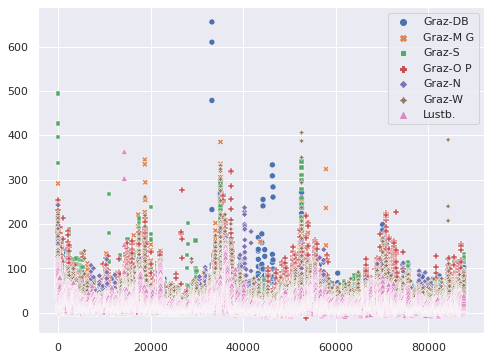

In [18]:
p = sns.scatterplot(data = df)

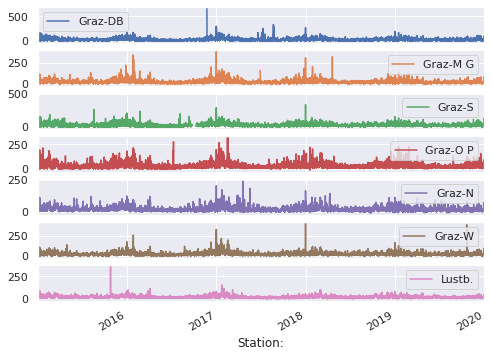

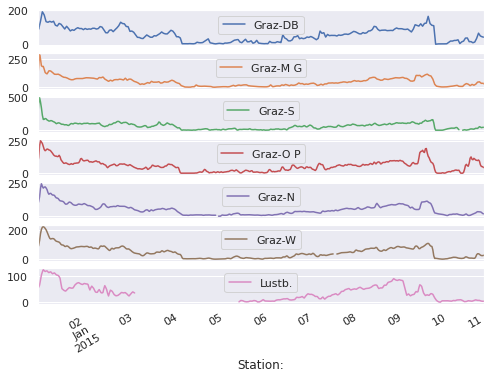

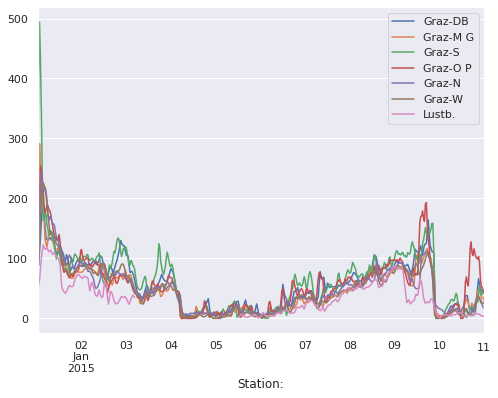

In [19]:
plot_cols = df.columns
plot_features = df[plot_cols]
plot_features.index = date_time
p = plot_features.plot(subplots=True)


plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
p = plot_features.plot(subplots=True)


plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
p = plot_features.plot(subplots=False)


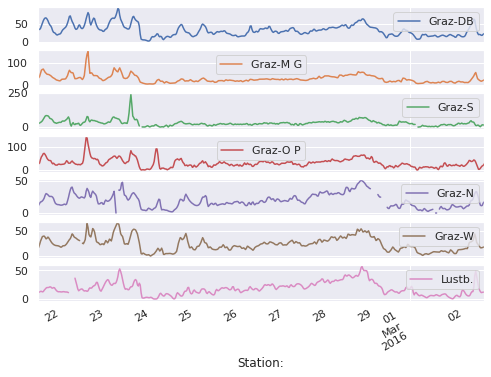

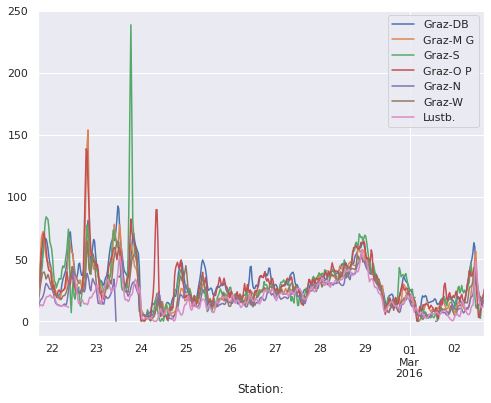

In [20]:
plot_features = df[plot_cols][20000:20480]
plot_features.index = date_time[20000:20480]
p = plot_features.plot(subplots=True)

plot_features = df[plot_cols][20000:20480]
plot_features.index = date_time[20000:20480]
p = plot_features.plot(subplots=False)


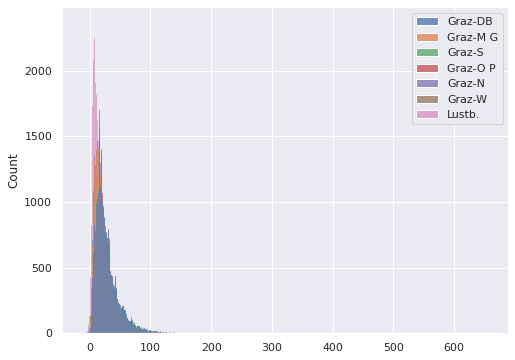

In [21]:
p = sns.histplot(df)

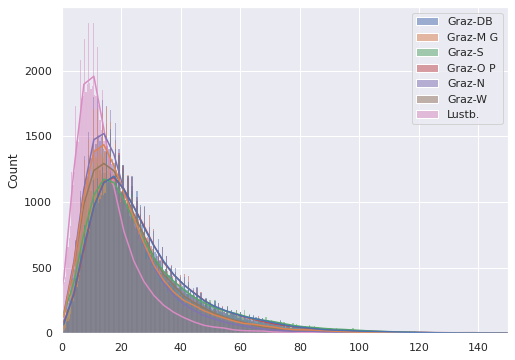

In [22]:
p = sns.histplot(df, kde= True).set(xlim=(0,150))

In [23]:
df.columns.size

7

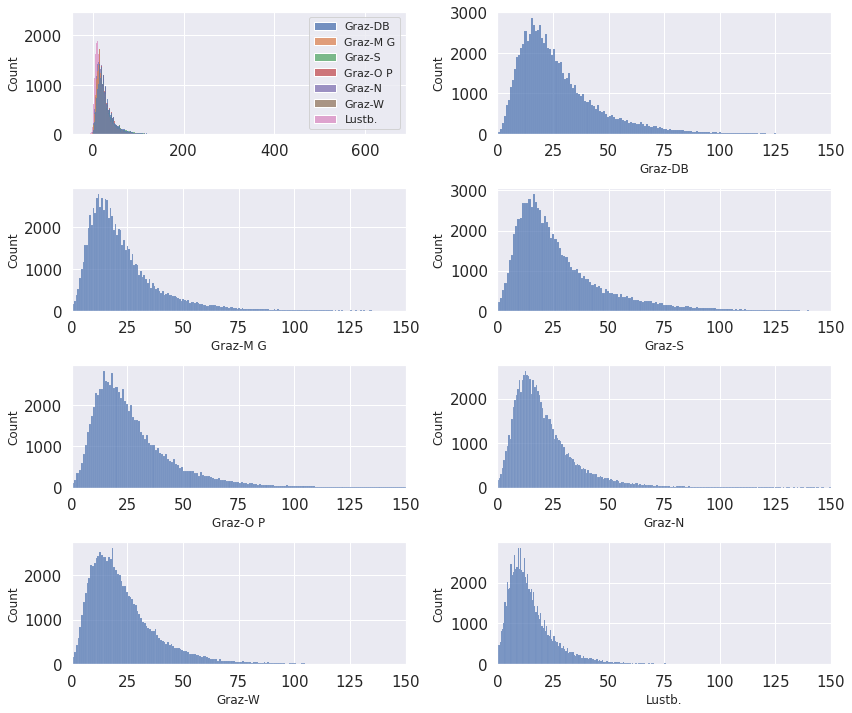

In [24]:
fig, ax = plt.subplots(4,2, figsize=(12,10))
jitter = [[False, 1], [0.5, 0.2]]


ax[0][0].tick_params(labelsize=15)
ax[0][0] = sns.histplot(  data=df, ax=ax[0][0])
ax[0][1].tick_params(labelsize=15)
ax[0][1] = sns.histplot(  data=df[df.columns[0]], ax=ax[0][1]).set(xlim=(0,150))

for j in range(1,len(ax)):
    for i in range(len(ax[j])):
        ax[j][i].tick_params(labelsize=15)
        ax[j][i] = sns.histplot(  data=df[df.columns[i+j*2-1]], ax=ax[j][i]).set(xlim=(0,150))
    
   
fig.tight_layout()

fig.show()


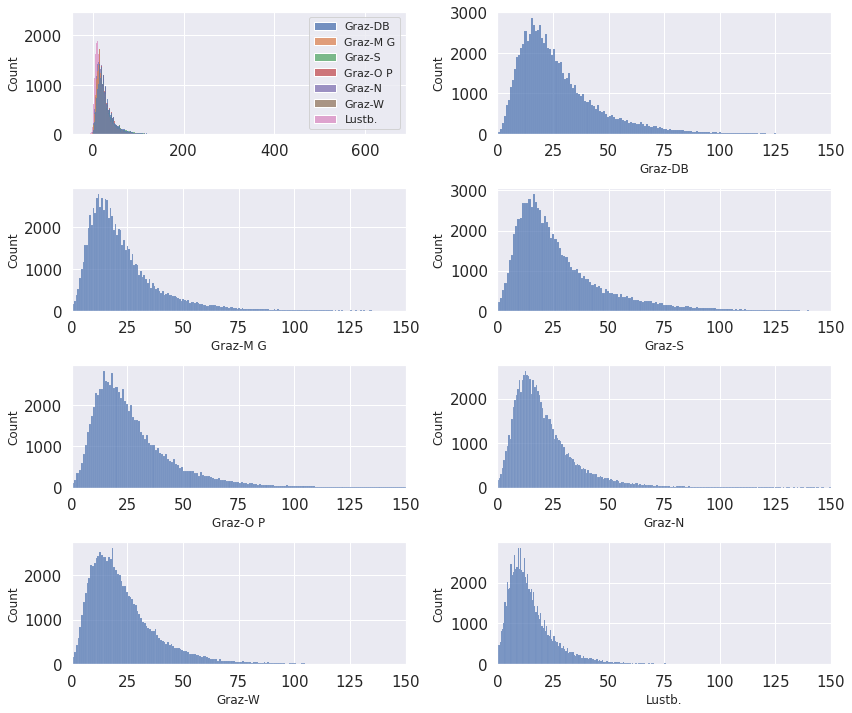

In [25]:
fig, ax = plt.subplots(4,2, figsize=(12,10))
jitter = [[False, 1], [0.5, 0.2]]
    
ax[0][0].tick_params(labelsize=15)
ax[0][0] = sns.histplot(  data=df, ax=ax[0][0])
ax[0][1].tick_params(labelsize=15)
ax[0][1] = sns.histplot(  data=df[df.columns[0]], ax=ax[0][1]).set(xlim=(0,150))
ax[1][0].tick_params(labelsize=15)
ax[1][0] = sns.histplot(  data=df[df.columns[1]], ax=ax[1][0]).set(xlim=(0,150))
ax[1][1].tick_params(labelsize=15)
ax[1][1] = sns.histplot(  data=df[df.columns[2]], ax=ax[1][1]).set(xlim=(0,150))
    
ax[2][0].tick_params(labelsize=15)
ax[2][0] = sns.histplot(  data=df[df.columns[3]], ax=ax[2][0]).set(xlim=(0,150))
ax[2][1].tick_params(labelsize=15)
ax[2][1] = sns.histplot(  data=df[df.columns[4]], ax=ax[2][1]).set(xlim=(0,150))
ax[3][0].tick_params(labelsize=15)
ax[3][0] = sns.histplot(  data=df[df.columns[5]], ax=ax[3][0]).set(xlim=(0,150))
ax[3][1].tick_params(labelsize=15)
ax[3][1] = sns.histplot(  data=df[df.columns[6]], ax=ax[3][1]).set(xlim=(0,150))
 
fig.tight_layout()

fig.show()


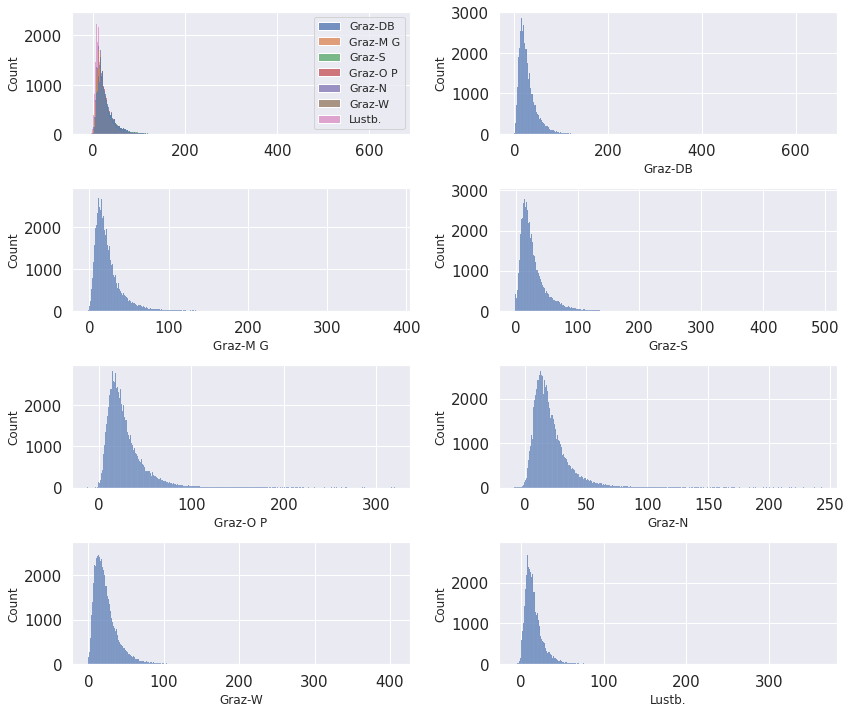

In [26]:
fig, ax = plt.subplots(4,2, figsize=(12,10))
jitter = [[False, 1], [0.5, 0.2]]

#for j in range(len(ax)):
#    for i in range(len(ax[j])):
#        ax[j][i].tick_params(labelsize=15)
#        ax[j][i] = sns.histplot(  data=df[df < 150][df >0][df.columns[i+j*2-1]], ax=ax[j][i])
     
ax[0][0].tick_params(labelsize=15)
ax[0][0] = sns.histplot(  data=df, ax=ax[0][0])
ax[0][1].tick_params(labelsize=15)
ax[0][1] = sns.histplot(  data=df[df.columns[0]], ax=ax[0][1])
ax[1][0].tick_params(labelsize=15)
ax[1][0] = sns.histplot(  data=df[df.columns[1]], ax=ax[1][0])
ax[1][1].tick_params(labelsize=15)
ax[1][1] = sns.histplot(  data=df[df.columns[2]], ax=ax[1][1])
    

ax[2][0].tick_params(labelsize=15)
ax[2][0] = sns.histplot(  data=df[df.columns[3]], ax=ax[2][0])
ax[2][1].tick_params(labelsize=15)
ax[2][1] = sns.histplot(  data=df[df.columns[4]], ax=ax[2][1])
ax[3][0].tick_params(labelsize=15)
ax[3][0] = sns.histplot(  data=df[df.columns[5]], ax=ax[3][0])
ax[3][1].tick_params(labelsize=15)
ax[3][1] = sns.histplot(  data=df[df.columns[6]], ax=ax[3][1])    
    
fig.tight_layout()

fig.show()


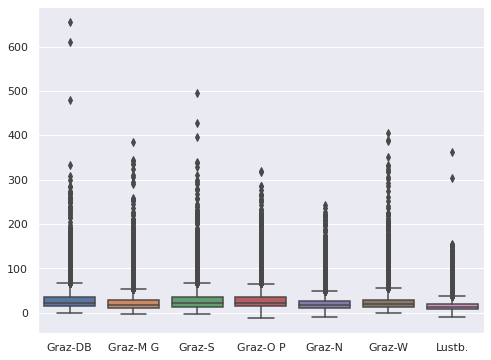

In [27]:
box = sns.boxplot(data=df)

[(0.0, 80.0)]

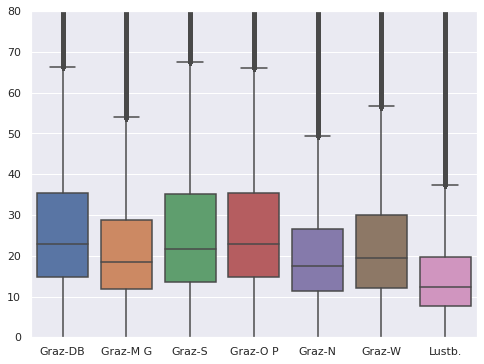

In [28]:
box = sns.boxplot(data=df)
box.set(ylim=(0,80))

# Features inspizieren

In [29]:
max_wind_date_time = pd.to_datetime(df_max_wind.pop('Station:'), format='%d.%m.%Y %H:%M:%S')
windrichtung_date_time = pd.to_datetime(df_windrichtung.pop('Station:'), format='%d.%m.%Y %H:%M:%S')
mittel_wind_date_time = pd.to_datetime(df_mittel_wind.pop('Station:'), format='%d.%m.%Y %H:%M:%S')
niederschlag_date_time = pd.to_datetime(df_niederschlag.pop('Station:'), format='%d.%m.%Y %H:%M:%S')
globalstr_date_time = pd.to_datetime(df_globalstr.pop('Station:'), format='%d.%m.%Y %H:%M:%S')
luftdruck_date_time = pd.to_datetime(df_luftdruck.pop('Station:'), format='%d.%m.%Y %H:%M:%S')
lufttemp_date_time = pd.to_datetime(df_lufttemp.pop('Station:'), format='%d.%m.%Y %H:%M:%S')
luftfreucht_date_time = pd.to_datetime(df_luftfeucht.pop('Station:'), format='%d.%m.%Y %H:%M:%S')

In [30]:
df_lufttemp=df_lufttemp.astype('float')
df_lufttemp.index = df_lufttemp.index -1

df_luftdruck=df_luftdruck.astype('float')
df_luftdruck.index = df_luftdruck.index -1

df_luftfeucht=df_luftfeucht.astype('float')
df_luftfeucht.index = df_luftfeucht.index -1

df_globalstr=df_globalstr.astype('float')
df_globalstr.index = df_globalstr.index -1

df_niederschlag=df_niederschlag.astype('float')
df_niederschlag.index = df_niederschlag.index -1

df_mittel_wind=df_mittel_wind.astype('float')
df_mittel_wind.index = df_mittel_wind.index -1

df_windrichtung = df_windrichtung.astype('float')
df_windrichtung.index = df_windrichtung.index -1

df_max_wind=df_max_wind.astype('float')
df_max_wind.index = df_max_wind.index -1

Die Indexis abgleichen

## Zeit

In [31]:
date_time

2       2015-01-01 00:30:00
3       2015-01-01 01:00:00
4       2015-01-01 01:30:00
5       2015-01-01 02:00:00
6       2015-01-01 02:30:00
                ...        
87645   2019-12-31 22:00:00
87646   2019-12-31 22:30:00
87647   2019-12-31 23:00:00
87648   2019-12-31 23:30:00
87649   2020-01-01 00:00:00
Name: Station:, Length: 87648, dtype: datetime64[ns]

In [32]:
lufttemp_date_time.index= lufttemp_date_time.index-1
luftdruck_date_time.index= luftdruck_date_time.index-1
luftfreucht_date_time.index= luftfreucht_date_time.index-1
globalstr_date_time.index= globalstr_date_time.index-1
niederschlag_date_time.index= niederschlag_date_time.index-1
mittel_wind_date_time.index= mittel_wind_date_time.index-1
windrichtung_date_time.index= windrichtung_date_time.index-1
max_wind_date_time.index= max_wind_date_time.index-1

In [33]:
print((date_time-lufttemp_date_time).max())
print((date_time-luftdruck_date_time).max())
print((date_time-luftfreucht_date_time).max())
print((date_time-globalstr_date_time).max())
print((date_time-niederschlag_date_time).max())
print((date_time-mittel_wind_date_time).max())
print((date_time-windrichtung_date_time).max())
print((date_time-max_wind_date_time).max())

0 days 00:00:00
0 days 00:00:00
0 days 00:00:00
0 days 00:00:00
0 days 00:00:00
0 days 00:00:00
0 days 00:00:00
0 days 00:00:00


## Daten - Temperatur

In [34]:
df_lufttemp.describe().transpose()

count       mean       std   min  25%   50%    75%   max
Graz-DB    87638.0  11.624602  8.905778 -14.6  4.6  11.6  18.50  37.1
Graz-M G   87492.0  12.351936  8.794099 -13.1  5.4  12.3  19.10  38.4
Graz-S     86789.0  11.414645  9.085498 -15.0  4.2  11.3  18.40  36.5
Graz-O P   45975.0  12.513670  9.079543 -14.2  5.3  12.8  19.40  38.0
Graz-N     87110.0  11.558528  8.689089 -15.0  4.7  11.4  18.10  36.9
Graz-W     87638.0  11.722835  8.834941 -14.2  4.8  11.6  18.40  37.0
Lustb.     87635.0  10.921200  8.281113 -14.4  4.4  11.0  17.20  34.9
Oeversee   87487.0  11.964972  8.767470 -14.4  5.0  12.0  18.65  37.6
Schloßb.   82069.0  11.697199  8.492499 -14.0  5.1  11.9  18.00  37.3
Plabut.    87575.0  10.183366  8.344268 -15.7  3.8  10.4  16.60  32.7
Kalkl.     86882.0  10.253413  8.083964 -15.3  4.1  10.4  16.50  32.3
Theissl.   86106.0   8.525452  7.889484 -17.2  2.5   8.7  14.50  31.0
Schöckl        0.0        NaN       NaN   NaN  NaN   NaN    NaN   NaN
Schöckl.1  81653.0   5.173787  7.726093 -20.4 -0.7   5.1  11.10  26.3

### Temp > 36 Grad < -10

In [35]:
d = pd.DataFrame(df_lufttemp > 36).sum().to_frame()['<-13'] = pd.DataFrame(df_lufttemp < -13).sum()
d

Graz-DB       43
Graz-M G       2
Graz-S        46
Graz-O P      27
Graz-N        33
Graz-W        31
Lustb.        29
Oeversee      22
Schloßb.      22
Plabut.      109
Kalkl.        66
Theissl.     201
Schöckl        0
Schöckl.1    386
dtype: int64

In [36]:
pd.DataFrame(df_lufttemp < -13).sum()

Graz-DB       43
Graz-M G       2
Graz-S        46
Graz-O P      27
Graz-N        33
Graz-W        31
Lustb.        29
Oeversee      22
Schloßb.      22
Plabut.      109
Kalkl.        66
Theissl.     201
Schöckl        0
Schöckl.1    386
dtype: int64

In [37]:
Stationen = pd.Series(df_lufttemp.isna().sum(), name='Temp_NaN').to_frame()
Stationen

Temp_NaN
Graz-DB          10
Graz-M G        156
Graz-S          859
Graz-O P      41673
Graz-N          538
Graz-W           10
Lustb.           13
Oeversee        161
Schloßb.       5579
Plabut.          73
Kalkl.          766
Theissl.       1542
Schöckl       87648
Schöckl.1      5995

### Ploten - Temp

In [38]:
sns.set()
sns.set_style('darkgrid')                          #set_style('darkgrid')  whitegrid

In [39]:
df=df_lufttemp


In [40]:
name = "Temp"

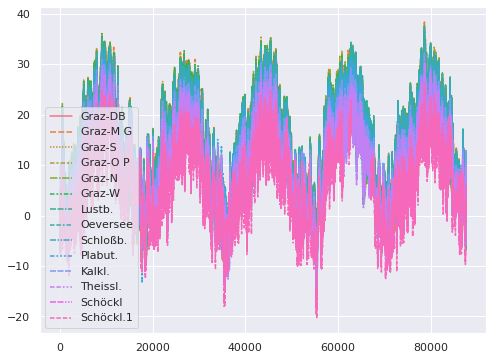

In [41]:
p = sns.lineplot(data = df)

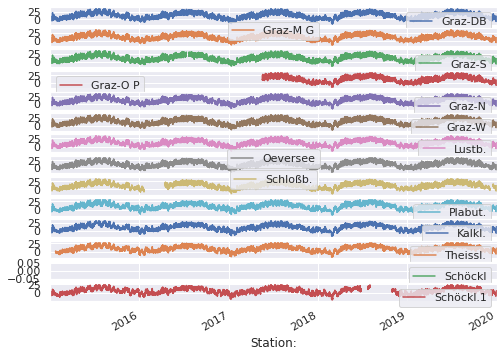

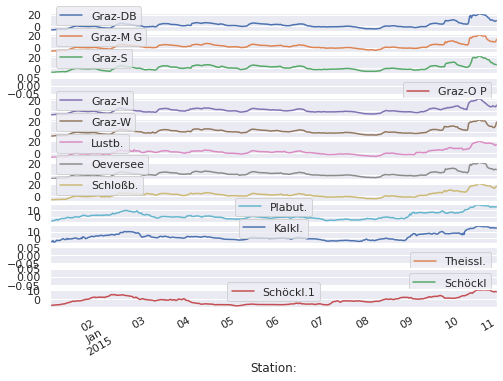

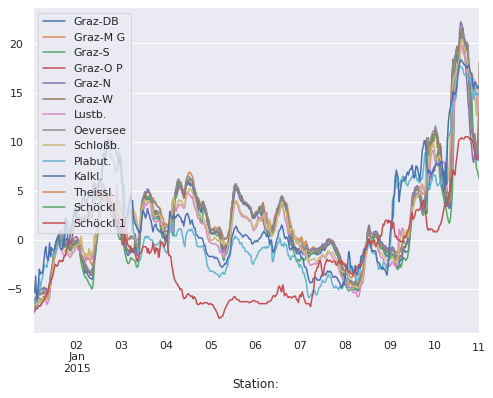

In [42]:
plot_cols = df.columns
plot_features = df[plot_cols]
plot_features.index = date_time
p = plot_features.plot(subplots=True)


plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
p = plot_features.plot(subplots=True)


plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
p = plot_features.plot(subplots=False)


In [43]:
df = df[['Graz-DB', 'Graz-M G', 'Graz-S', 'Graz-N', 'Graz-W', 'Lustb.']]


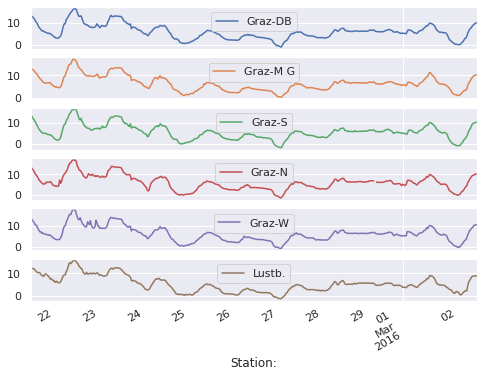

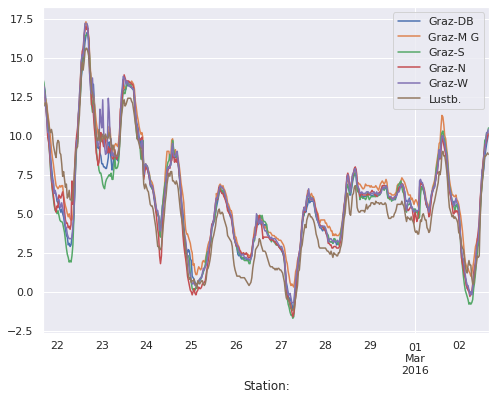

In [44]:
plot_cols = df.columns
plot_features = df[plot_cols][20000:20480]
plot_features.index = date_time[20000:20480]
p = plot_features.plot(subplots=True)


plot_features = df[plot_cols][20000:20480]
plot_features.index = date_time[20000:20480]
p = plot_features.plot(subplots=False)


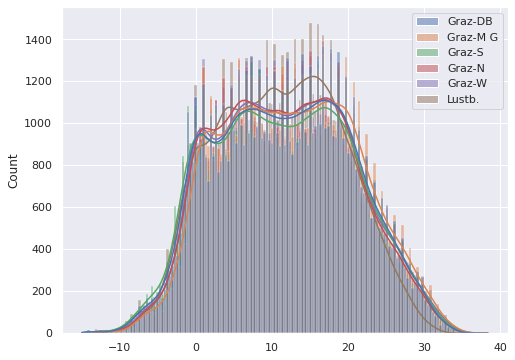

In [45]:
p = sns.histplot(df, kde=True)

In [46]:
df.columns.size

6

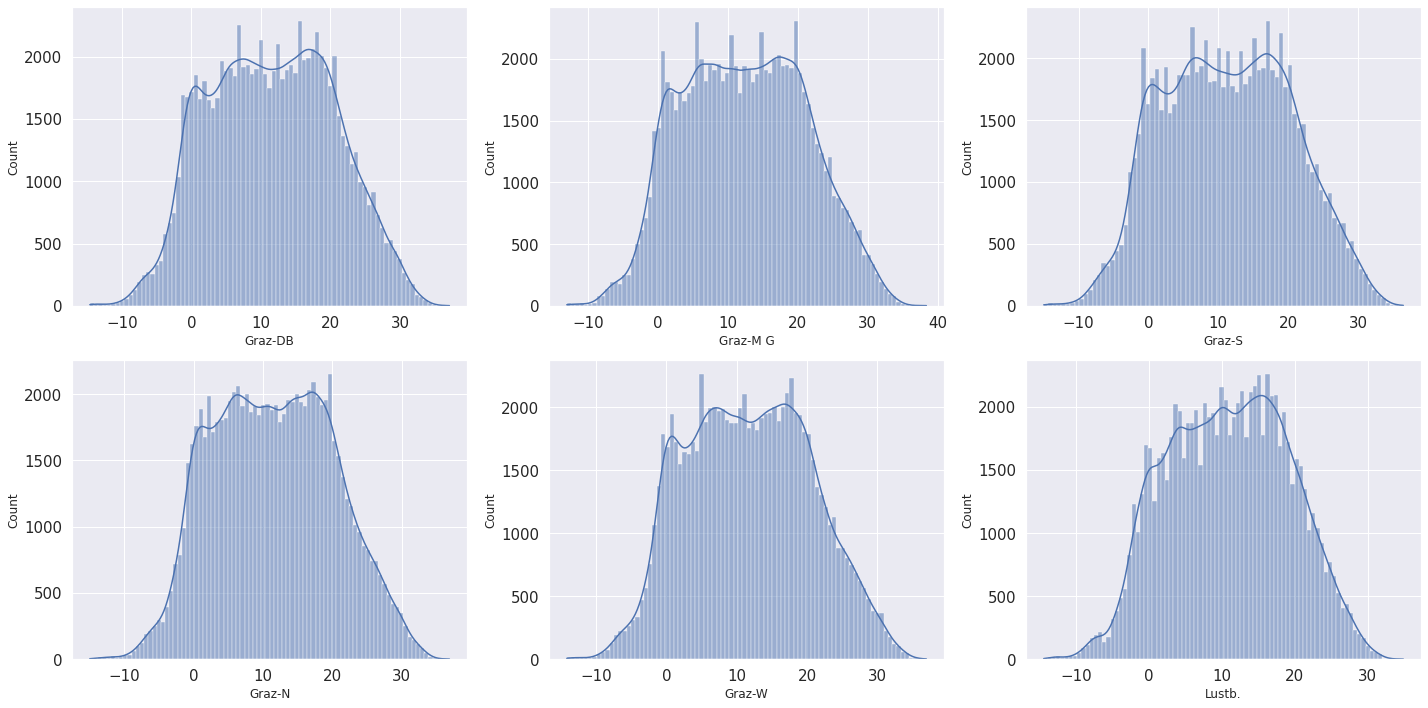

In [47]:
fig, ax = plt.subplots(2,3, figsize=(20,10))
jitter = [[False, 1], [0.5, 0.2]]

for j in range(len(ax)):
    for i in range(len(ax[j])):
        ax[j][i].tick_params(labelsize=15)
        ax[j][i] = sns.histplot(  data=df[df.columns[j*3+i]], ax=ax[j][i], kde=True)
     
  
    
fig.tight_layout()

fig.show()


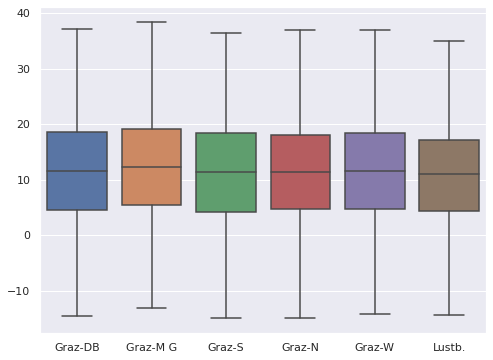

In [48]:
box = sns.boxplot(data=df)


### Ausschlüsse

keine Weiteren -> schauen gut aus

## Feucht

### Daten

In [49]:
df = df_luftfeucht
name = "Feucht"
df

Graz-DB  Graz-M G  Graz-S  Graz-O P  Graz-N  Graz-W  Lustb.  Oeversee  \
2         75.0      70.0    77.0       NaN    76.0    75.0    70.0      67.0   
3         77.0      71.0    77.0       NaN    78.0    77.0    74.0      68.0   
4         78.0      72.0    77.0       NaN    81.0    78.0    74.0      69.0   
5         78.0      72.0    76.0       NaN    81.0    79.0    74.0      68.0   
6         78.0      72.0    76.0       NaN    79.0    79.0    75.0      69.0   
...        ...       ...     ...       ...     ...     ...     ...       ...   
87645     86.0      79.0    88.0      85.0    85.0    81.0    66.0      77.0   
87646     88.0      79.0    89.0      86.0    88.0    82.0    63.0      78.0   
87647     89.0      81.0    90.0      87.0    89.0    84.0    62.0      81.0   
87648     91.0      82.0    90.0      87.0    88.0    86.0    63.0      84.0   
87649     92.0      83.0    90.0      88.0    90.0    88.0    64.0      83.0   

       Schloßb.  Plabut.  Kalkl.  Theissl.  Schöckl  Schöckl.1  
2          69.0     59.0    35.0       NaN      NaN       93.0  
3          70.0     62.0    36.0       NaN      NaN       93.0  
4          72.0     61.0    38.0       NaN      NaN       93.0  
5          73.0     56.0    37.0       NaN      NaN       93.0  
6          73.0     54.0    56.0       NaN      NaN       93.0  
...         ...      ...     ...       ...      ...        ...  
87645      59.0     57.0    47.0      49.0      NaN       55.0  
87646      59.0     54.0    47.0      51.0      NaN       57.0  
87647      58.0     51.0    51.0      52.0      NaN       60.0  
87648      62.0     52.0    49.0      54.0      NaN       62.0  
87649      64.0     59.0    49.0      52.0      NaN       61.0  

[87648 rows x 14 columns]

In [50]:
df.describe().T

count       mean        std   min   25%   50%   75%    max
Graz-DB    87638.0  72.879436  19.930348  22.0  55.0  78.0  92.0   99.0
Graz-M G   87491.0  68.230104  17.367906  26.0  53.0  71.0  84.0   98.0
Graz-S     87375.0  73.113328  19.102336  14.0  58.0  77.0  90.0  100.0
Graz-O P   45869.0  77.223811  20.745165  13.0  63.0  81.0  97.0  104.0
Graz-N     87110.0  72.425439  17.976465  28.0  56.0  75.0  89.0   99.0
Graz-W     87480.0  69.742090  21.534530  17.0  50.0  75.0  90.0  101.0
Lustb.     87635.0  74.399783  17.789458  16.0  61.0  75.0  90.0  100.0
Oeversee   84111.0  70.380105  19.612955  14.0  53.0  72.0  88.0  101.0
Schloßb.   82419.0  68.740606  19.419003  23.0  52.0  70.0  86.0  100.0
Plabut.    86460.0  66.797513  18.788478  16.0  52.0  65.0  82.0  101.0
Kalkl.     87265.0  63.242583  18.730264  12.0  48.0  60.0  78.0  101.0
Theissl.   85824.0  73.716280  16.870823  10.0  63.0  74.0  87.0  100.0
Schöckl        0.0        NaN        NaN   NaN   NaN   NaN   NaN    NaN
Schöckl.1  81565.0  78.400037  17.850515   4.0  68.0  81.0  93.0  100.0

In [51]:
df.columns

Index(['Graz-DB', 'Graz-M G', 'Graz-S', 'Graz-O P', 'Graz-N', 'Graz-W',
       'Lustb.', 'Oeversee', 'Schloßb.', 'Plabut.', 'Kalkl.', 'Theissl.',
       'Schöckl', 'Schöckl.1'],
      dtype='object')

In [52]:
Stationen['Feucht>100'] = (df > 100).sum()

In [53]:
(df < 0).sum()

Graz-DB      0
Graz-M G     0
Graz-S       0
Graz-O P     0
Graz-N       0
Graz-W       0
Lustb.       0
Oeversee     0
Schloßb.     0
Plabut.      0
Kalkl.       0
Theissl.     0
Schöckl      0
Schöckl.1    0
dtype: int64

In [54]:
Stationen['Feucht_NaN'] = (df.isna()).sum()
Stationen[Stationen.columns[1:]]

Feucht>100  Feucht_NaN
Graz-DB             0          10
Graz-M G            0         157
Graz-S              0         273
Graz-O P           38       41779
Graz-N              0         538
Graz-W             39         168
Lustb.              0          13
Oeversee          451        3537
Schloßb.            0        5229
Plabut.           588        1188
Kalkl.              2         383
Theissl.            0        1824
Schöckl             0       87648
Schöckl.1           0        6083

Alle Spalten:

['Graz-DB', 'Graz-M G', 'Graz-S', 'Graz-O P', 'Graz-N', 'Graz-W','Lustb.', 'Oeversee', 'Schloßb.', 'Plabut.', 'Kalkl.', 'Theissl.',
       'Schöckl', 'Schöckl.1']
       
Ausfall:

- Schöckl  -> keine Daten
- Graz-O P -> viel Fehlende Daten


### Plot

In [55]:
df=df_luftfeucht[['Graz-DB', 'Graz-M G', 'Graz-S', 'Graz-N', 'Graz-W',
       'Lustb.']]

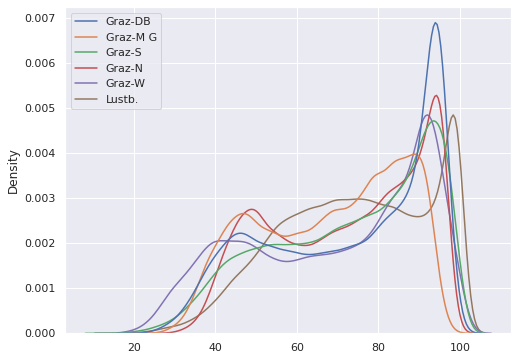

In [56]:
p = sns.kdeplot(data = df)

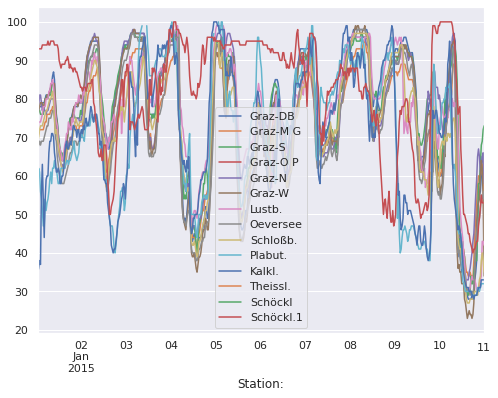

In [57]:
plot_cols = df_luftfeucht.columns
plot_features = df_luftfeucht[plot_cols][:480]
plot_features.index = date_time[:480]
p = plot_features.plot(subplots=False)


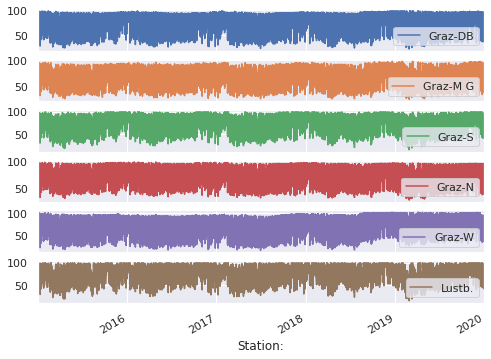

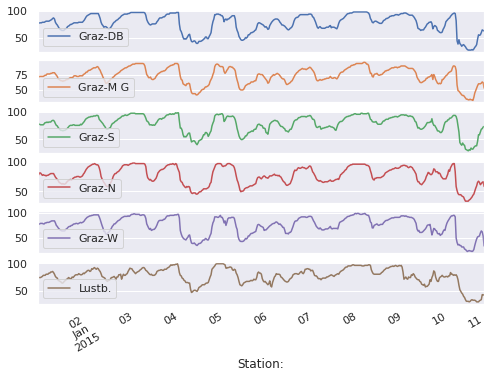

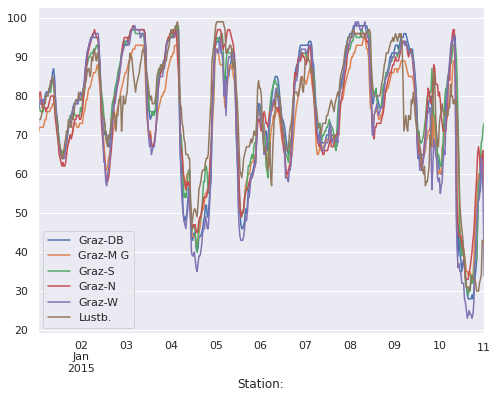

In [58]:
plot_cols = df.columns
plot_features = df[plot_cols]
plot_features.index = date_time
p = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
p = plot_features.plot(subplots=True)


plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
p = plot_features.plot(subplots=False)


Alle Spalten:

['Graz-DB', 'Graz-M G', 'Graz-S', 'Graz-O P', 'Graz-N', 'Graz-W','Lustb.', 'Oeversee', 'Schloßb.', 'Plabut.', 'Kalkl.', 'Theissl.',
       'Schöckl', 'Schöckl.1']
       
Ausfall:

- Schöckl  -> keine Daten
- Graz-O P -> viel Fehlende Daten

- 'Oeversee', 'Schloßb.', 'Plabut.', 'Kalkl.', 'Theissl.', 'Schöckl', 'Schöckl.1' -> nicht von Graz (ganz andere Verläufe)

In [59]:
df

Graz-DB  Graz-M G  Graz-S  Graz-N  Graz-W  Lustb.
2         75.0      70.0    77.0    76.0    75.0    70.0
3         77.0      71.0    77.0    78.0    77.0    74.0
4         78.0      72.0    77.0    81.0    78.0    74.0
5         78.0      72.0    76.0    81.0    79.0    74.0
6         78.0      72.0    76.0    79.0    79.0    75.0
...        ...       ...     ...     ...     ...     ...
87645     86.0      79.0    88.0    85.0    81.0    66.0
87646     88.0      79.0    89.0    88.0    82.0    63.0
87647     89.0      81.0    90.0    89.0    84.0    62.0
87648     91.0      82.0    90.0    88.0    86.0    63.0
87649     92.0      83.0    90.0    90.0    88.0    64.0

[87648 rows x 6 columns]

In [60]:
Stationen['Feucht_vrwbr'] = (Stationen.index.isin(df.T.index))

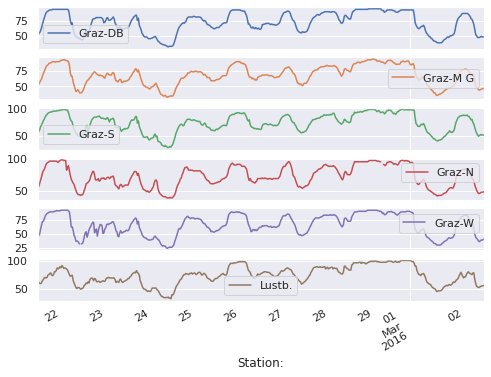

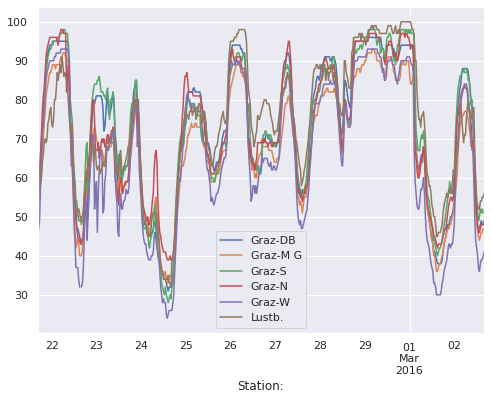

In [61]:
plot_features = df[plot_cols][20000:20480]
plot_features.index = date_time[20000:20480]
p = plot_features.plot(subplots=True)


plot_features = df[plot_cols][20000:20480]
plot_features.index = date_time[20000:20480]
p = plot_features.plot(subplots=False)


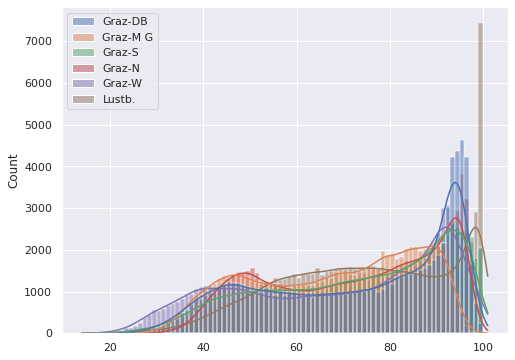

In [62]:
arr = np.array(range(df.min().min().astype('int'),df.max().max().astype('int')))

p = sns.histplot(df, kde=True, bins=arr)

Lustbühl schaut anders aus.

Erhebung in Graz, genauer anschauen

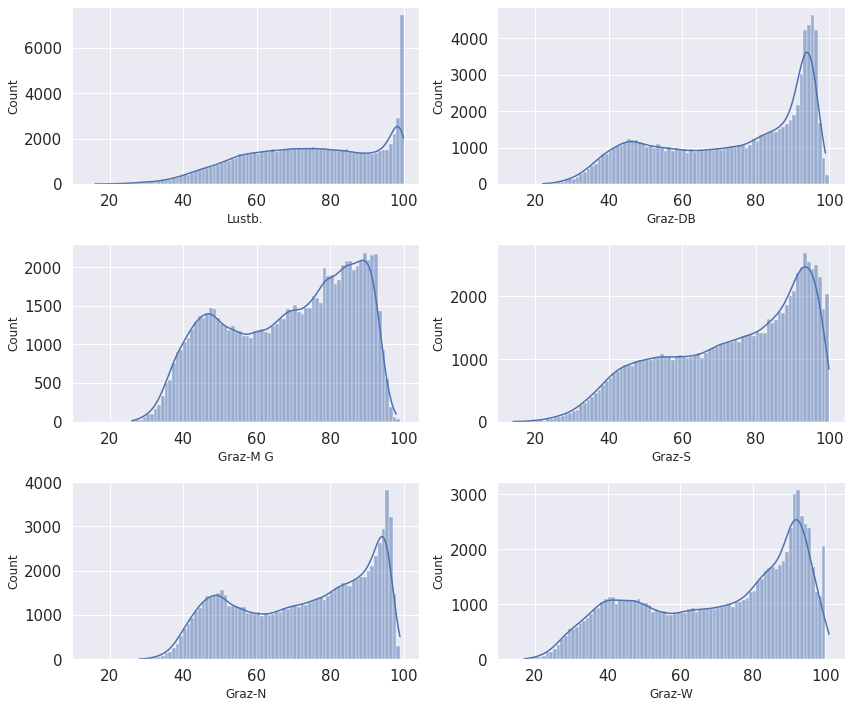

In [63]:
fig, ax = plt.subplots(3,2, figsize=(12,10))



for j in range(len(ax)):
    for i in range(len(ax[j])):
        ax[j][i].tick_params(labelsize=15)
        ax[j][i] = sns.histplot(  data=df[df.columns[i+j*2-1]], ax=ax[j][i], kde=True, bins=arr)
     
  
    
fig.tight_layout()

fig.show()


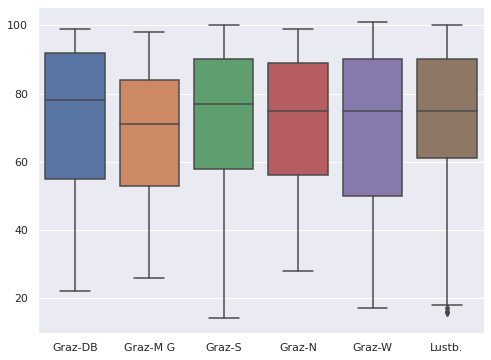

In [64]:
box = sns.boxplot(data=df)


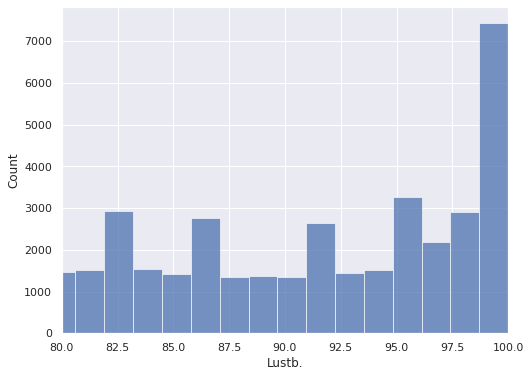

In [65]:
p = sns.histplot(data= df['Lustb.']).set(xlim=(80,100))


## Druck

### Daten

In [66]:
df = df_luftdruck
name = "Druck"
df.isna().sum()

Graz-DB      87648
Graz-M G     87648
Graz-S       87648
Graz-O P     41673
Graz-N         538
Graz-W       87648
Lustb.       87648
Oeversee     68090
Schloßb.     87648
Plabut.      87648
Kalkl.       87648
Theissl.     67679
Schöckl      87648
Schöckl.1     6006
dtype: int64

In [67]:
df = df[['Graz-N','Schöckl.1']]

In [68]:
df.describe().T

count        mean       std    min    25%     50%    75%    max
Graz-N     87110.0  977.322731  7.392501  936.5  973.0  977.40  981.8  999.5
Schöckl.1  81642.0  849.037369  7.020619  809.3  844.8  850.05  854.1  866.1

In [69]:
Stationen['Druck_NaN'] = (df.isna()).sum()
Stationen

Temp_NaN  Feucht>100  Feucht_NaN  Feucht_vrwbr  Druck_NaN
Graz-DB          10           0          10          True        NaN
Graz-M G        156           0         157          True        NaN
Graz-S          859           0         273          True        NaN
Graz-O P      41673          38       41779         False        NaN
Graz-N          538           0         538          True      538.0
Graz-W           10          39         168          True        NaN
Lustb.           13           0          13          True        NaN
Oeversee        161         451        3537         False        NaN
Schloßb.       5579           0        5229         False        NaN
Plabut.          73         588        1188         False        NaN
Kalkl.          766           2         383         False        NaN
Theissl.       1542           0        1824         False        NaN
Schöckl       87648           0       87648         False        NaN
Schöckl.1      5995           0        6083         False     6006.0

Alle Spalten:

nur Nord und Schöckl


### Plot

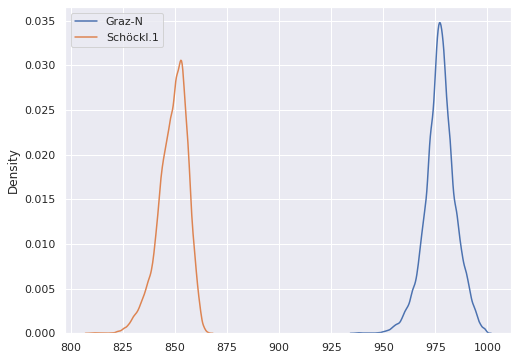

In [70]:
p = sns.kdeplot(data = df)

-> Kann man nicht ersetzen

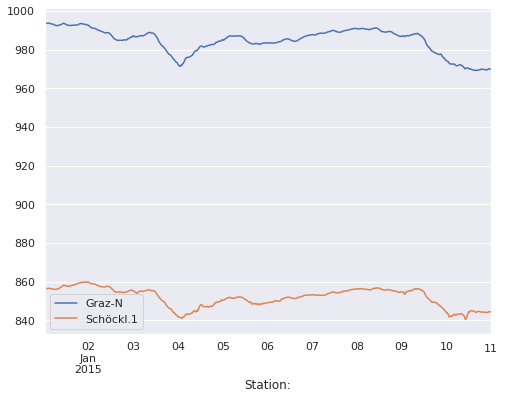

In [71]:
plot_cols = df.columns
plot_features = df_luftdruck[plot_cols][:480]
plot_features.index = date_time[:480]
p = plot_features.plot(subplots=False)


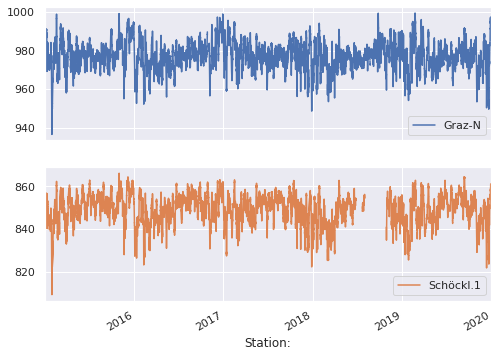

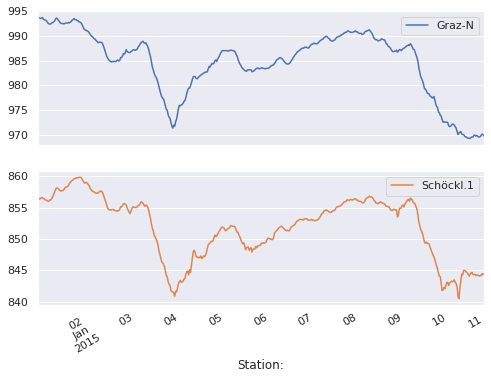

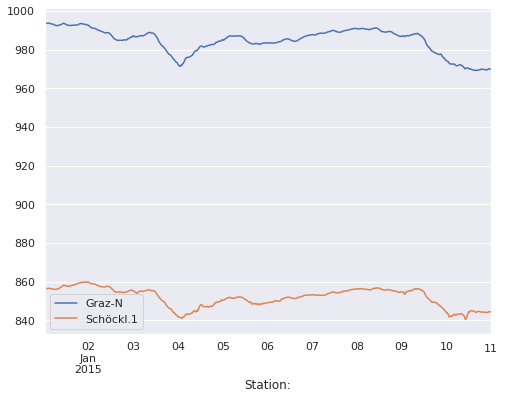

In [72]:
plot_cols = df.columns
plot_features = df[plot_cols]
plot_features.index = date_time
p = plot_features.plot(subplots=True)


plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
p = plot_features.plot(subplots=True)


plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
p = plot_features.plot(subplots=False)


In [73]:
df = df[['Graz-N']]

In [74]:
Stationen['Druck_vrwbr'] = (Stationen.index.isin(df.T.index))

In [75]:
Stationen

Temp_NaN  Feucht>100  Feucht_NaN  Feucht_vrwbr  Druck_NaN  \
Graz-DB          10           0          10          True        NaN   
Graz-M G        156           0         157          True        NaN   
Graz-S          859           0         273          True        NaN   
Graz-O P      41673          38       41779         False        NaN   
Graz-N          538           0         538          True      538.0   
Graz-W           10          39         168          True        NaN   
Lustb.           13           0          13          True        NaN   
Oeversee        161         451        3537         False        NaN   
Schloßb.       5579           0        5229         False        NaN   
Plabut.          73         588        1188         False        NaN   
Kalkl.          766           2         383         False        NaN   
Theissl.       1542           0        1824         False        NaN   
Schöckl       87648           0       87648         False        NaN   
Schöckl.1      5995           0        6083         False     6006.0   

           Druck_vrwbr  
Graz-DB          False  
Graz-M G         False  
Graz-S           False  
Graz-O P         False  
Graz-N            True  
Graz-W           False  
Lustb.           False  
Oeversee         False  
Schloßb.         False  
Plabut.          False  
Kalkl.           False  
Theissl.         False  
Schöckl          False  
Schöckl.1        False

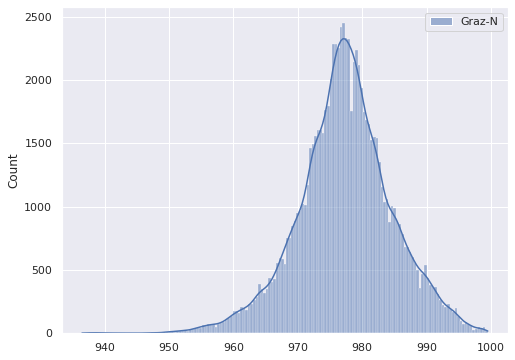

In [76]:
p = sns.histplot(df, kde=True)

Lustbühl schaut anders aus.

Erhebung in Graz, genauer anschauen

## Globalstrahlung

### Daten

In [77]:
df = df_globalstr
name = "Globalstrahlung"
df.isna().sum()

Graz-DB      87648
Graz-M G     87648
Graz-S       87648
Graz-O P     87648
Graz-N        1572
Graz-W       87648
Lustb.        5675
Oeversee     87648
Schloßb.     87648
Plabut.      87648
Kalkl.       87648
Theissl.     87648
Schöckl      87648
Schöckl.1     5964
dtype: int64

In [78]:
df.describe().T

count        mean         std  min  25%  50%      75%     max
Graz-DB        0.0         NaN         NaN  NaN  NaN  NaN      NaN     NaN
Graz-M G       0.0         NaN         NaN  NaN  NaN  NaN      NaN     NaN
Graz-S         0.0         NaN         NaN  NaN  NaN  NaN      NaN     NaN
Graz-O P       0.0         NaN         NaN  NaN  NaN  NaN      NaN     NaN
Graz-N     86076.0  151.869563  239.716834  0.0  2.3  7.3  218.525  1116.0
Graz-W         0.0         NaN         NaN  NaN  NaN  NaN      NaN     NaN
Lustb.     81973.0   94.206491  176.459987  0.0  0.0  1.2  101.300  1059.8
Oeversee       0.0         NaN         NaN  NaN  NaN  NaN      NaN     NaN
Schloßb.       0.0         NaN         NaN  NaN  NaN  NaN      NaN     NaN
Plabut.        0.0         NaN         NaN  NaN  NaN  NaN      NaN     NaN
Kalkl.         0.0         NaN         NaN  NaN  NaN  NaN      NaN     NaN
Theissl.       0.0         NaN         NaN  NaN  NaN  NaN      NaN     NaN
Schöckl        0.0         NaN         NaN  NaN  NaN  NaN      NaN     NaN
Schöckl.1  81684.0  139.967144  220.061591  0.0  0.0  4.0  214.700  1125.0

In [79]:
df = df[['Graz-N','Lustb.', 'Schöckl.1']]
df.describe().T

count        mean         std  min  25%  50%      75%     max
Graz-N     86076.0  151.869563  239.716834  0.0  2.3  7.3  218.525  1116.0
Lustb.     81973.0   94.206491  176.459987  0.0  0.0  1.2  101.300  1059.8
Schöckl.1  81684.0  139.967144  220.061591  0.0  0.0  4.0  214.700  1125.0

In [80]:
df.isna().sum()

Graz-N       1572
Lustb.       5675
Schöckl.1    5964
dtype: int64

In [81]:
5964/816.84

7.301307477596591

bis zu 7% nan

Graz-N brauchbar

In [82]:
Stationen['Globalst_NaN'] = pd.DataFrame(df.isna()).sum()

### Plot

In [83]:
unterschied = df[['Lustb.', 'Schöckl.1']].divide(df['Graz-N']/100, axis=0)
unterschied['Lustb.orig'] = df[['Lustb.']]
unterschied['Graz-N'] = df[['Graz-N']]

<AxesSubplot:ylabel='Count'>

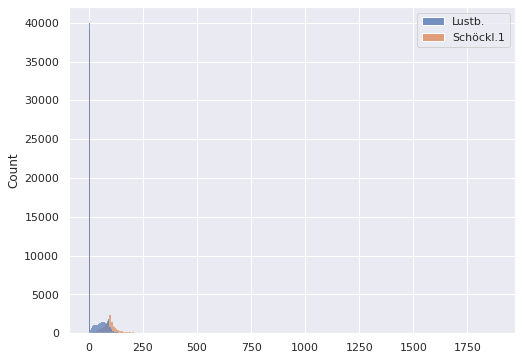

In [84]:
sns.histplot(data = unterschied[['Lustb.', 'Schöckl.1']]) 

In [85]:
unterschied[['Lustb.', 'Schöckl.1']][unterschied > 150].count()


Lustb.        510
Schöckl.1    6336
dtype: int64

jahresabhändigkeit?

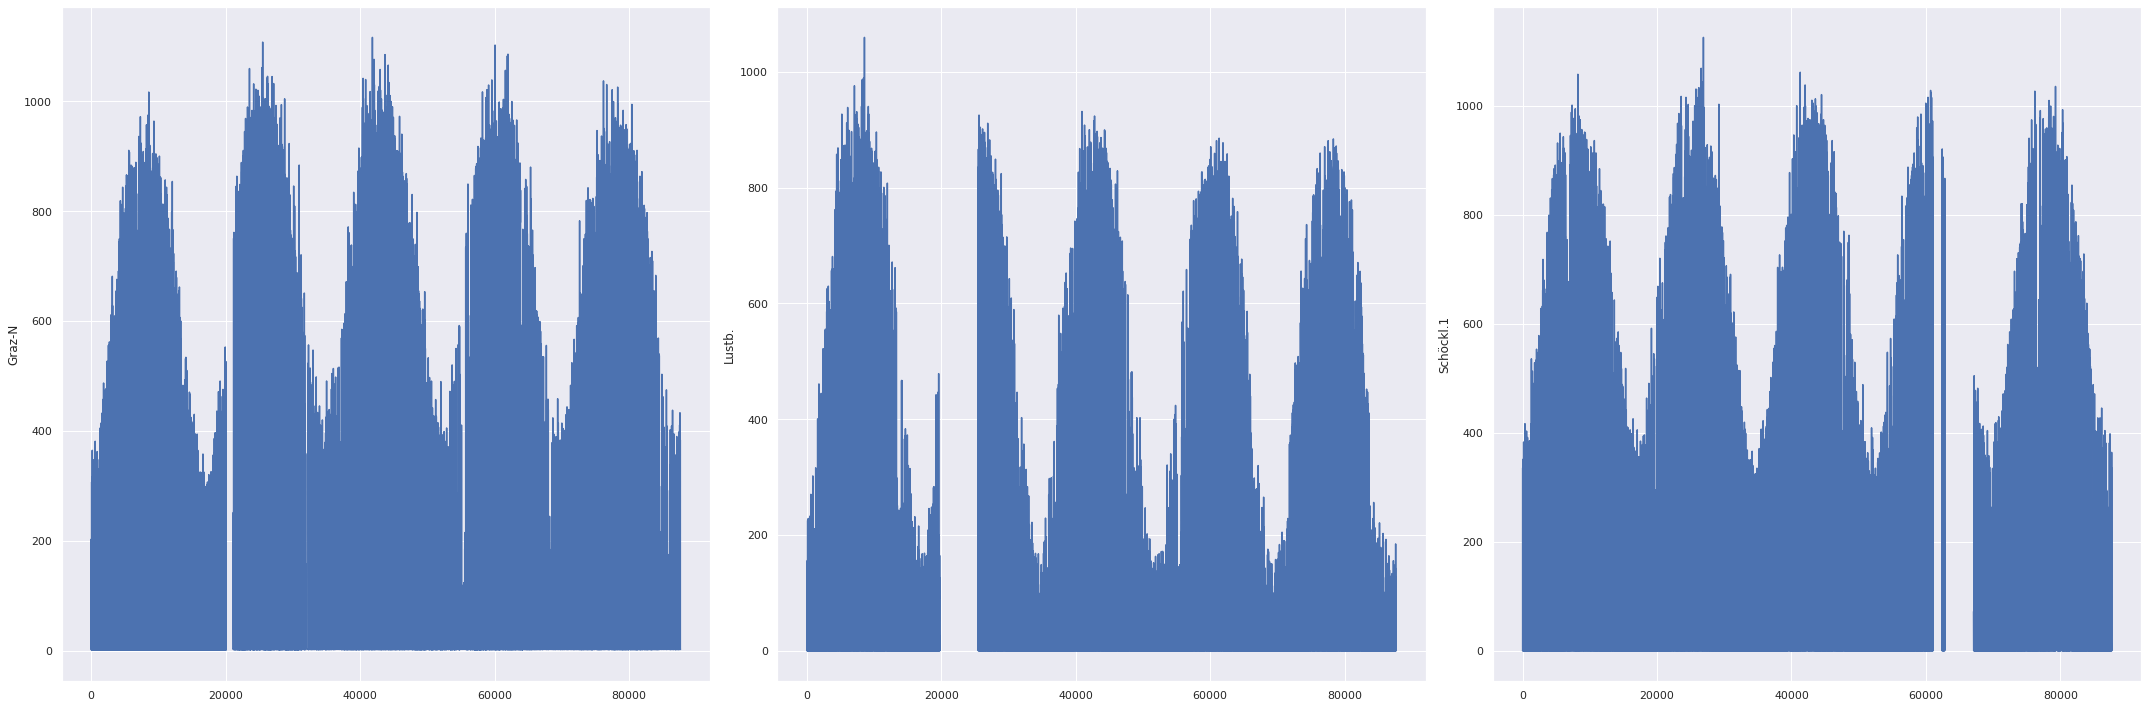

In [86]:
#p = sns.lineplot(data = df['Graz-N']describefig, axs = count.subplots(ncols=3, figsize=(30,10))
fig, axs = plt.subplots(ncols=3, figsize=(30,10))


sns.lineplot( data=df[df.columns[0]], ax=axs[0])
sns.lineplot( data=df[df.columns[1]], ax=axs[1])
sns.lineplot( data=df[df.columns[2]], ax=axs[2])


    
fig.tight_layout()

fig.show()

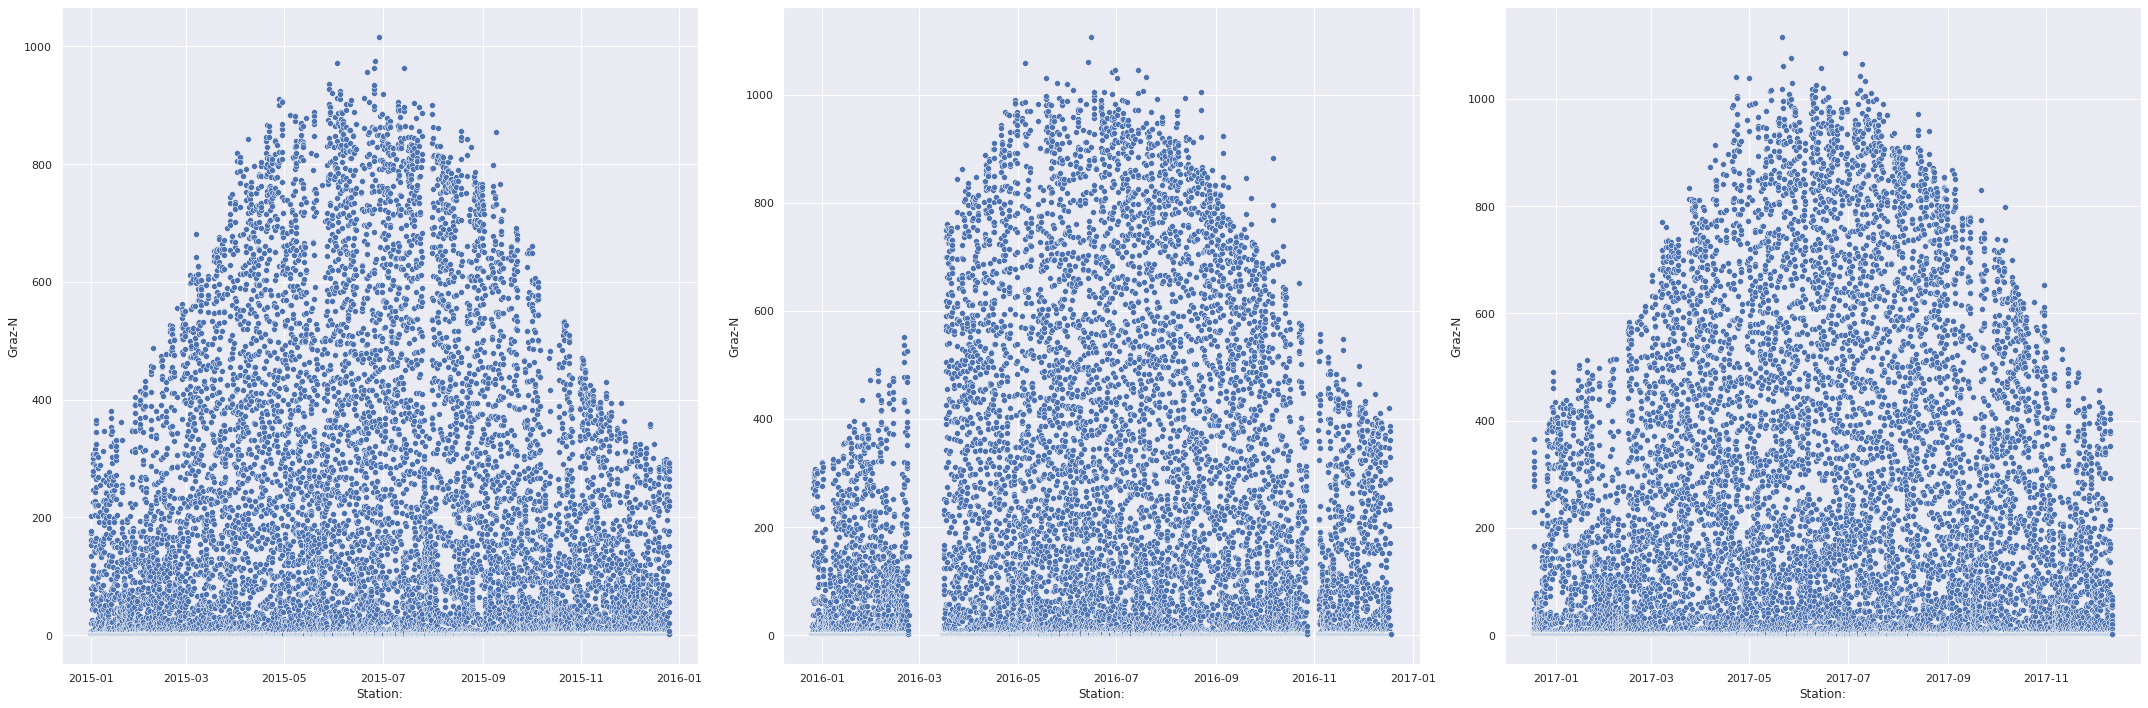

In [87]:
df_h = df.copy()
df_h.index = globalstr_date_time

teil = df_h.count().max()//5

fig, axs = plt.subplots(ncols=3, figsize=(30,10))

sns.scatterplot( data=df_h[df_h.columns[0]][:teil], ax=axs[0])
sns.scatterplot( data=df_h[df_h.columns[0]][teil:teil*2], ax=axs[1])
sns.scatterplot( data=df_h[df_h.columns[0]][teil*2:teil*3], ax=axs[2])

fig.tight_layout()

fig.show()

### -> Spiegelt Jahreszeiten 
Sommer am Höchsten (Juni)

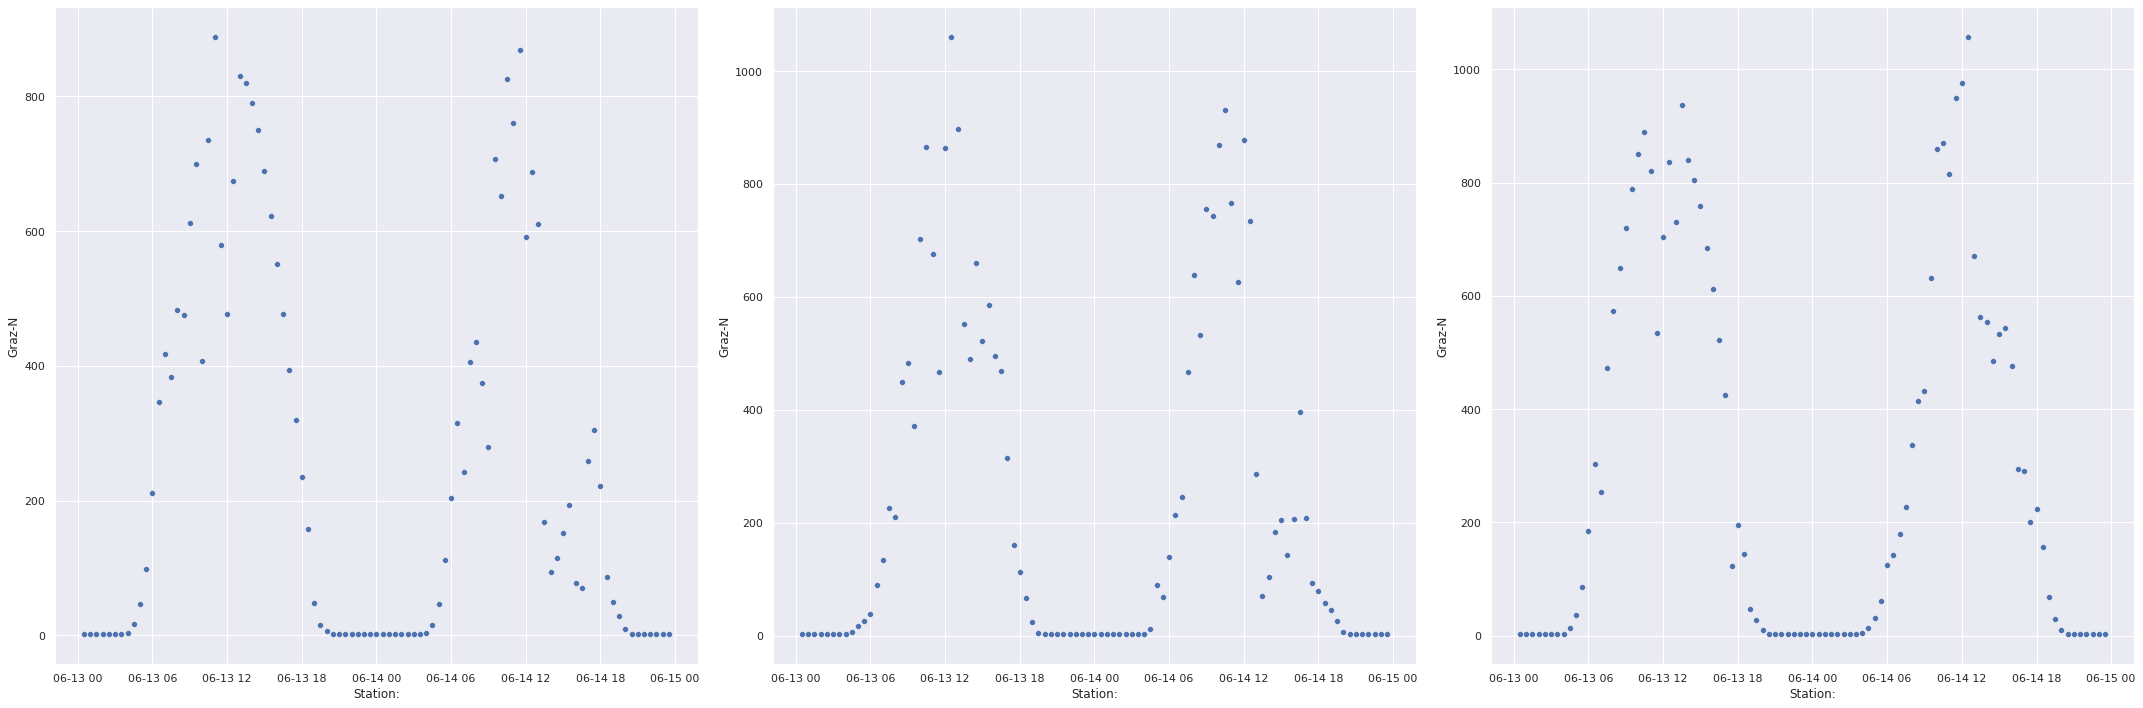

In [88]:
df_h = df.copy()
df_h.index = globalstr_date_time

teil = df_h.count().max()//5

fig, axs = plt.subplots(ncols=3, figsize=(30,10))

sns.scatterplot( data=df_h[df_h.columns[0]][(df_h.index < '2015-06-15') & (df_h.index > '2015-06-13')], ax=axs[0])
sns.scatterplot( data=df_h[df_h.columns[0]][(df_h.index < '2016-06-15') & (df_h.index > '2016-06-13')], ax=axs[1])
sns.scatterplot( data=df_h[df_h.columns[0]][(df_h.index < '2017-06-15') & (df_h.index > '2017-06-13')], ax=axs[2])


fig.tight_layout()

fig.show()

### -> Spiegelt Tageszeiten 


## Niederschlag

### Daten

In [89]:
df = df_niederschlag
name = "Niederschlag"
df.isna().sum()

Graz-DB      87648
Graz-M G     87648
Graz-S       87648
Graz-O P     87648
Graz-N         550
Graz-W       87648
Lustb.       87648
Oeversee     87648
Schloßb.     87648
Plabut.      87648
Kalkl.       87648
Theissl.     87648
Schöckl      87648
Schöckl.1     6036
dtype: int64

In [90]:
df.describe().T

count      mean       std  min  25%  50%  75%    max
Graz-DB        0.0       NaN       NaN  NaN  NaN  NaN  NaN    NaN
Graz-M G       0.0       NaN       NaN  NaN  NaN  NaN  NaN    NaN
Graz-S         0.0       NaN       NaN  NaN  NaN  NaN  NaN    NaN
Graz-O P       0.0       NaN       NaN  NaN  NaN  NaN  NaN    NaN
Graz-N     87098.0  0.040424  0.350148  0.0  0.0  0.0  0.0  26.82
Graz-W         0.0       NaN       NaN  NaN  NaN  NaN  NaN    NaN
Lustb.         0.0       NaN       NaN  NaN  NaN  NaN  NaN    NaN
Oeversee       0.0       NaN       NaN  NaN  NaN  NaN  NaN    NaN
Schloßb.       0.0       NaN       NaN  NaN  NaN  NaN  NaN    NaN
Plabut.        0.0       NaN       NaN  NaN  NaN  NaN  NaN    NaN
Kalkl.         0.0       NaN       NaN  NaN  NaN  NaN  NaN    NaN
Theissl.       0.0       NaN       NaN  NaN  NaN  NaN  NaN    NaN
Schöckl        0.0       NaN       NaN  NaN  NaN  NaN  NaN    NaN
Schöckl.1  81612.0  0.045292  0.414173  0.0  0.0  0.0  0.0  34.60

In [91]:
df = df[['Graz-N','Schöckl.1']]

In [92]:
df.index = niederschlag_date_time

In [93]:
pd.DataFrame(df.isna()).sum()

Graz-N        550
Schöckl.1    6036
dtype: int64

In [94]:
Stationen['Niederschlag_NaN'] = pd.DataFrame(df.isna()).sum()
pd.DataFrame(df.isna()).sum()

Graz-N        550
Schöckl.1    6036
dtype: int64

Nur Graz Nord und Schöckl 1 zu brauchen
Graz Nord viel weniger Löcher

### Plot

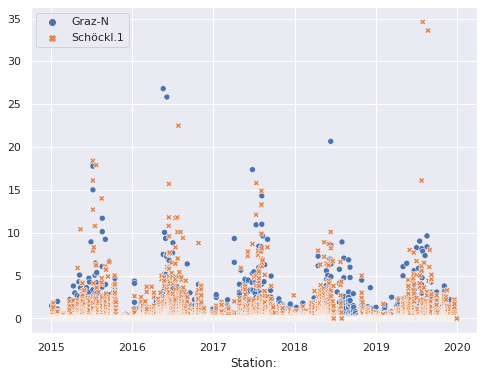

In [95]:
p = sns.scatterplot(data = df)

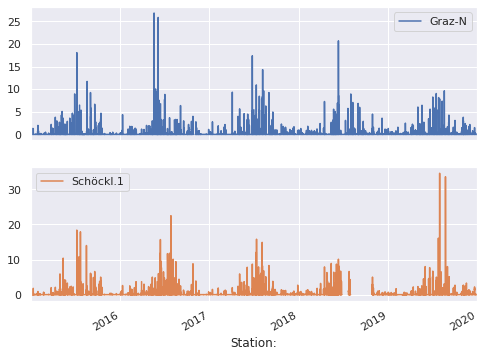

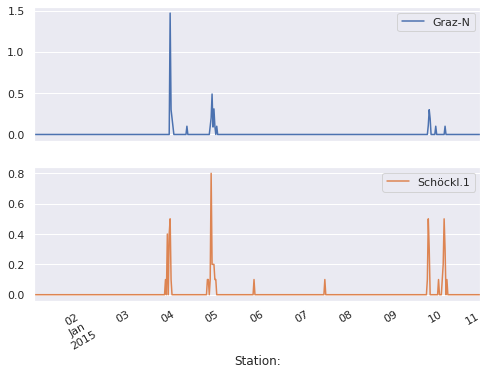

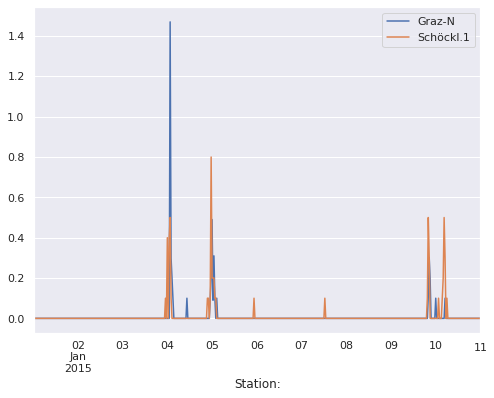

In [96]:
plot_cols = df.columns
plot_features = df[plot_cols]
plot_features.index = date_time
p = plot_features.plot(subplots=True)


plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
p = plot_features.plot(subplots=True)


plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
p = plot_features.plot(subplots=False)


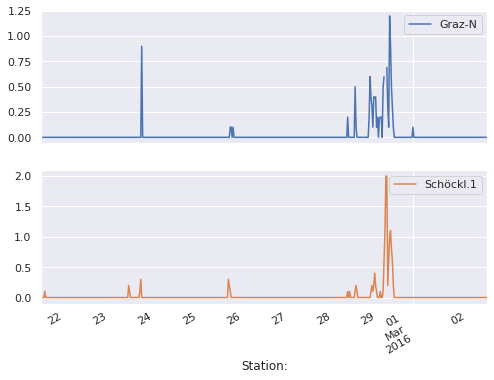

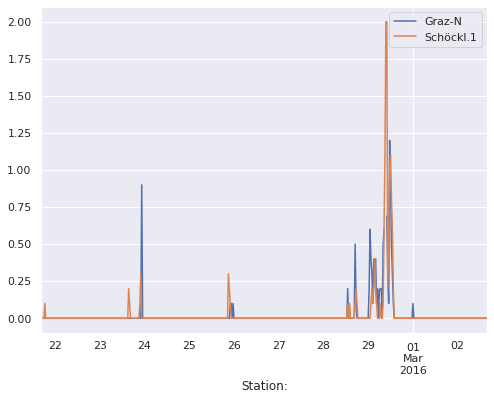

In [97]:
plot_features = df[plot_cols][20000:20480]
plot_features.index = date_time[20000:20480]
p = plot_features.plot(subplots=True)


plot_features = df[plot_cols][20000:20480]
plot_features.index = date_time[20000:20480]
p = plot_features.plot(subplots=False)


übereinstimmungen im Niederschlag

Abhängigkeit Jahreszeitlich?

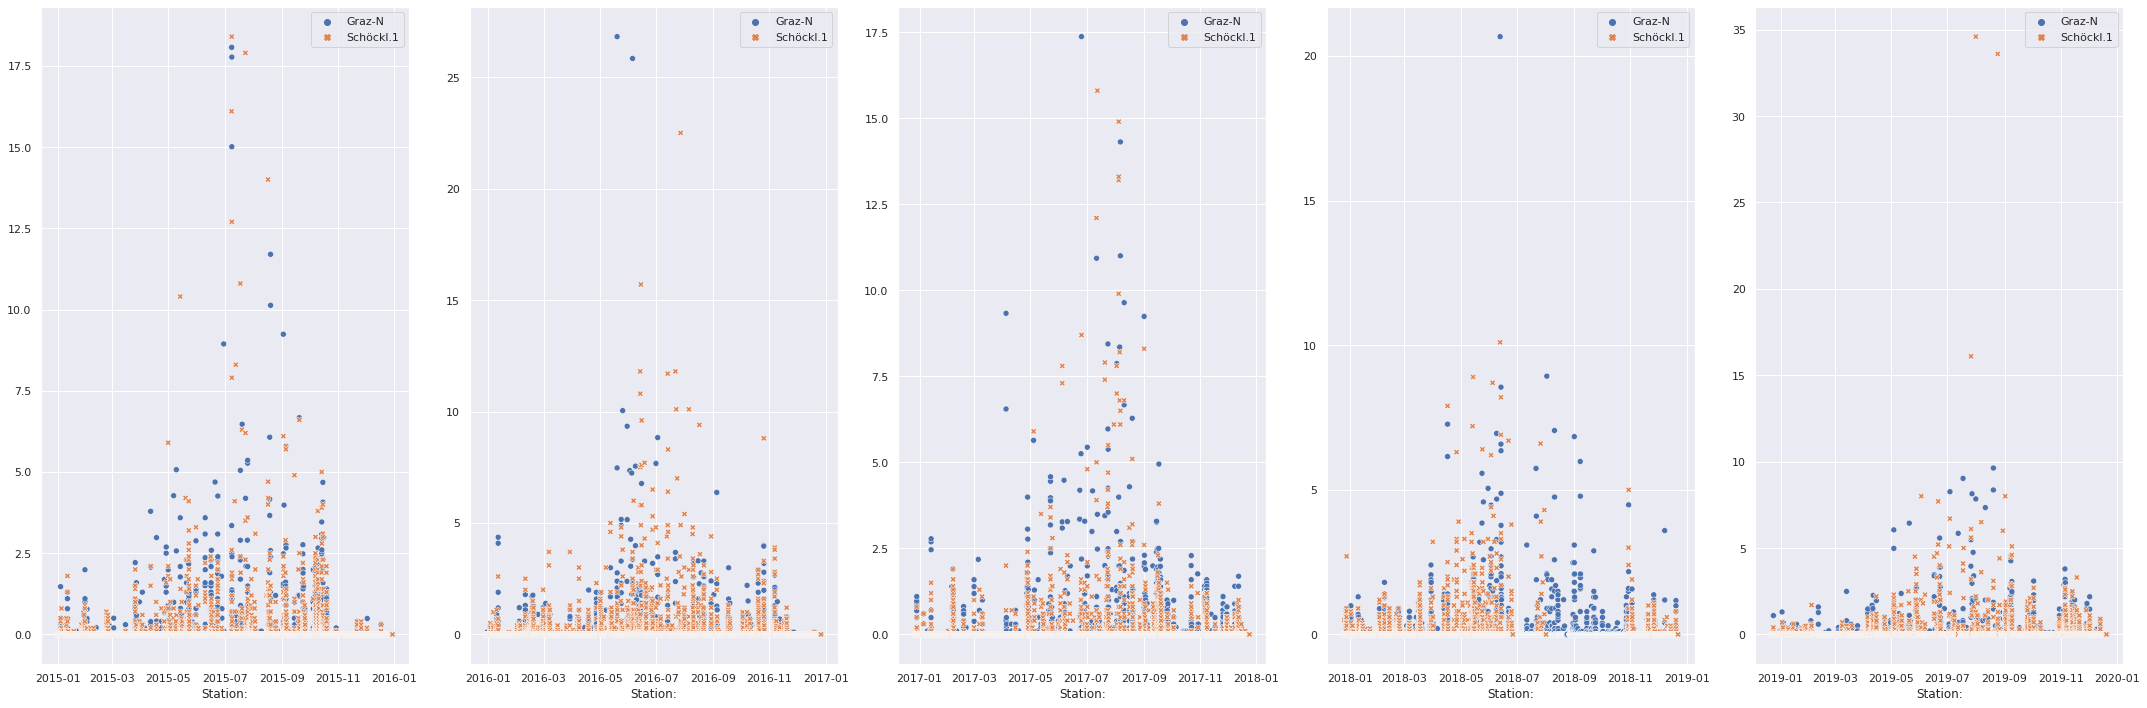

In [98]:
df_h = df.copy()

teil = df_h.count()[0]//5

fig, axs = plt.subplots(ncols=5, figsize=(30,10))

sns.scatterplot( data=df_h[:teil], ax=axs[0])
sns.scatterplot( data=df_h[teil:teil*2], ax=axs[1])
sns.scatterplot( data=df_h[teil*2:teil*3], ax=axs[2])
sns.scatterplot( data=df_h[teil*3:teil*4], ax=axs[3])
sns.scatterplot( data=df_h[teil*4:teil*5], ax=axs[4])

fig.tight_layout()

fig.show()


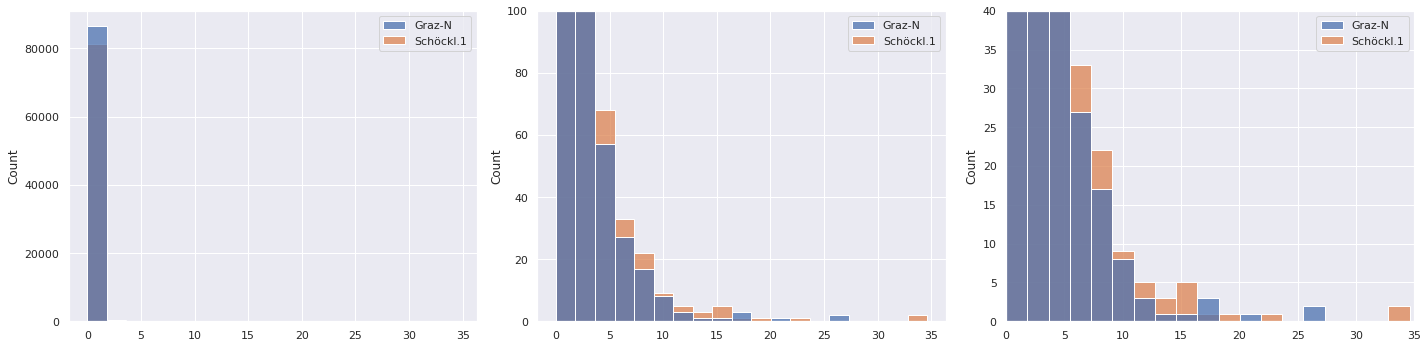

In [99]:
fig, axs = plt.subplots(ncols=3, figsize=(20,5))

sns.histplot( data=df, ax=axs[0])
sns.histplot(data = df, ax=axs[1]).set(ylim=(0,100))
sns.histplot(df, ax=axs[2]).set(xlim=(0,35),ylim=(0,40))

fig.tight_layout()

fig.show()


### Niederschlag Abhängigkeiten

Sommer viel mehr Niederschlag

## Wind

### Daten

In [100]:
df = df_mittel_wind 
name = "Wind"
df.isna().sum()

Graz-DB      87648
Graz-M G     87648
Graz-S         276
Graz-O P     41706
Graz-N         539
Graz-W          15
Lustb.          13
Oeversee      1248
Schloßb.      7027
Plabut.        149
Kalkl.         360
Theissl.     87648
Schöckl      87648
Schöckl.1     6020
dtype: int64

In [101]:
df = df[['Graz-S',  'Graz-N', 'Graz-W','Lustb.', 'Oeversee', 'Schloßb.']].add_suffix('_Mittel')
df.describe().T

count      mean       std  min  25%  50%  75%   max
Graz-S_Mittel    87372.0  0.782189  0.807325  0.0  0.2  0.5  1.1   6.7
Graz-N_Mittel    87109.0  0.749375  0.609287  0.0  0.3  0.6  1.0   6.8
Graz-W_Mittel    87633.0  0.619526  0.603965  0.0  0.2  0.4  0.8   6.2
Lustb._Mittel    87635.0  0.444186  0.365105  0.0  0.2  0.3  0.6   5.5
Oeversee_Mittel  86400.0  0.662541  0.474458  0.0  0.3  0.6  0.9   5.0
Schloßb._Mittel  80621.0  2.577319  1.780111  0.0  1.2  2.2  3.8  15.9

In [102]:
df_max_wind

Graz-DB  Graz-M G  Graz-S  Graz-O P  Graz-N  Graz-W  Lustb.  Oeversee  \
2          NaN       NaN     1.3       NaN     0.9     1.1     0.5       0.9   
3          NaN       NaN     0.6       NaN     0.5     0.5     0.6       0.9   
4          NaN       NaN     1.0       NaN     0.5     0.7     0.6       1.1   
5          NaN       NaN     1.0       NaN     0.5     1.0     0.6       0.8   
6          NaN       NaN     1.0       NaN     0.9     1.3     0.5       1.5   
...        ...       ...     ...       ...     ...     ...     ...       ...   
87645      NaN       NaN     1.2       1.5     1.9     1.6     1.8       1.8   
87646      NaN       NaN     1.1       1.2     1.3     1.9     1.4       2.1   
87647      NaN       NaN     1.3       1.7     2.9     1.0     1.1       1.5   
87648      NaN       NaN     1.3       1.5     2.1     1.4     1.3       1.7   
87649      NaN       NaN     1.1       1.3     2.1     1.1     1.6       1.5   

       Schloßb.  Plabut.  Kalkl.  Theissl.  Schöckl  Schöckl.1  
2           1.4      1.9     1.7       NaN      NaN        9.8  
3           1.1      2.3     1.5       NaN      NaN        9.9  
4           0.9      2.5     1.8       NaN      NaN       10.7  
5           1.3      2.8     2.6       NaN      NaN       11.0  
6           1.6      3.2     1.9       NaN      NaN       11.6  
...         ...      ...     ...       ...      ...        ...  
87645       1.9      5.5     1.6       NaN      NaN       17.1  
87646       1.7      5.5     3.4       NaN      NaN       18.0  
87647       3.5      3.8     2.6       NaN      NaN       18.7  
87648       2.7      3.9     4.1       NaN      NaN       13.6  
87649       1.3      5.9     2.8       NaN      NaN       13.5  

[87648 rows x 14 columns]

In [103]:
df_mittel_wind.isna().sum()

Graz-DB      87648
Graz-M G     87648
Graz-S         276
Graz-O P     41706
Graz-N         539
Graz-W          15
Lustb.          13
Oeversee      1248
Schloßb.      7027
Plabut.        149
Kalkl.         360
Theissl.     87648
Schöckl      87648
Schöckl.1     6020
dtype: int64

In [104]:
Stationen['Wind_NaN'] = df_mittel_wind.isna().sum() + df_max_wind.isna().sum()

In [105]:
df = df.join( df_max_wind[[ 'Graz-S', 'Graz-N', 'Graz-W','Lustb.', 'Oeversee', 'Schloßb.']].add_suffix('_Max') )
df.head()

Graz-S_Mittel  Graz-N_Mittel  Graz-W_Mittel  Lustb._Mittel  \
2            0.3            0.1            0.3            0.2   
3            0.1            0.2            0.2            0.2   
4            0.3            0.2            0.3            0.4   
5            0.3            0.2            0.3            0.2   
6            0.4            0.4            0.4            0.2   

   Oeversee_Mittel  Schloßb._Mittel  Graz-S_Max  Graz-N_Max  Graz-W_Max  \
2              0.4              0.8         1.3         0.9         1.1   
3              0.4              0.3         0.6         0.5         0.5   
4              0.4              0.2         1.0         0.5         0.7   
5              0.3              0.4         1.0         0.5         1.0   
6              0.5              0.6         1.0         0.9         1.3   

   Lustb._Max  Oeversee_Max  Schloßb._Max  
2         0.5           0.9           1.4  
3         0.6           0.9           1.1  
4         0.6           1.1           0.9  
5         0.6           0.8           1.3  
6         0.5           1.5           1.6

In [106]:
pd.DataFrame(df.isna()).sum()

Graz-S_Mittel       276
Graz-N_Mittel       539
Graz-W_Mittel        15
Lustb._Mittel        13
Oeversee_Mittel    1248
Schloßb._Mittel    7027
Graz-S_Max          246
Graz-N_Max          505
Graz-W_Max           13
Lustb._Max           13
Oeversee_Max       1250
Schloßb._Max       6875
dtype: int64

In [107]:
df = df.drop(columns=['Schloßb._Mittel','Schloßb._Max'])

### Plot

/home/pmf/MachineLearning/venvs/cpu/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


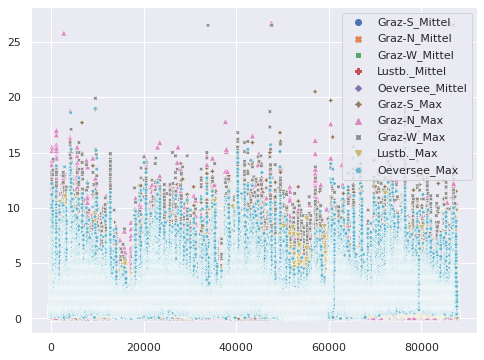

In [108]:
p = sns.scatterplot(data = df)

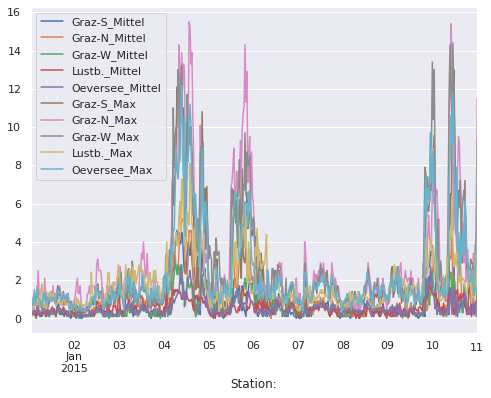

In [109]:
plot_cols = df.columns
plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
p = plot_features.plot(subplots=False)


In [110]:
df

Graz-S_Mittel  Graz-N_Mittel  Graz-W_Mittel  Lustb._Mittel  \
2                0.3            0.1            0.3            0.2   
3                0.1            0.2            0.2            0.2   
4                0.3            0.2            0.3            0.4   
5                0.3            0.2            0.3            0.2   
6                0.4            0.4            0.4            0.2   
...              ...            ...            ...            ...   
87645            0.3            0.4            0.2            0.4   
87646            0.1            0.2            0.4            0.1   
87647            0.2            0.7            0.1            0.6   
87648            0.3            0.3            0.1            1.3   
87649            0.1            0.5            0.5            1.0   

       Oeversee_Mittel  Graz-S_Max  Graz-N_Max  Graz-W_Max  Lustb._Max  \
2                  0.4         1.3         0.9         1.1         0.5   
3                  0.4         0.6         0.5         0.5         0.6   
4                  0.4         1.0         0.5         0.7         0.6   
5                  0.3         1.0         0.5         1.0         0.6   
6                  0.5         1.0         0.9         1.3         0.5   
...                ...         ...         ...         ...         ...   
87645              0.5         1.2         1.9         1.6         1.8   
87646              0.6         1.1         1.3         1.9         1.4   
87647              0.1         1.3         2.9         1.0         1.1   
87648              0.2         1.3         2.1         1.4         1.3   
87649              0.6         1.1         2.1         1.1         1.6   

       Oeversee_Max  
2               0.9  
3               0.9  
4               1.1  
5               0.8  
6               1.5  
...             ...  
87645           1.8  
87646           2.1  
87647           1.5  
87648           1.7  
87649           1.5  

[87648 rows x 10 columns]

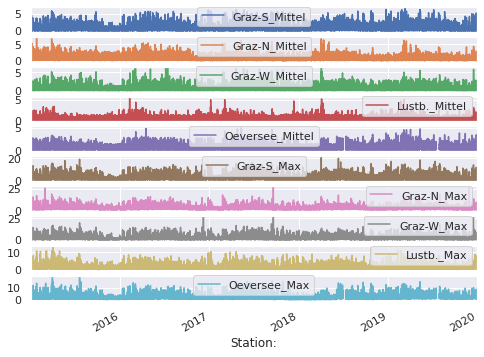

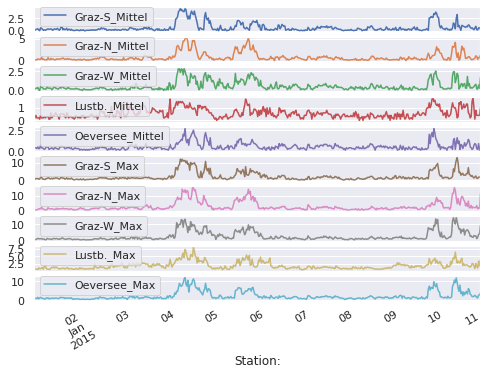

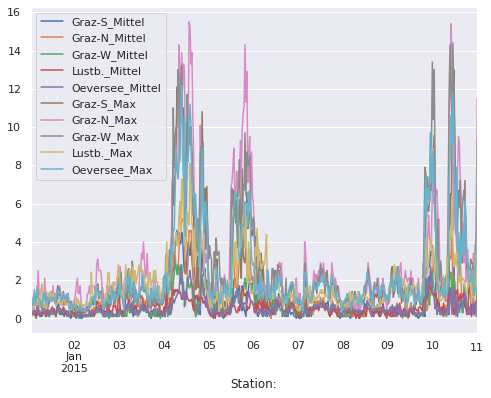

In [111]:
plot_cols = df.columns
plot_features = df[plot_cols]
plot_features.index = date_time
p = plot_features.plot(subplots=True)


plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
p = plot_features.plot(subplots=True)


plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
p = plot_features.plot(subplots=False)


Alle Spalten:

['Graz-DB', 'Graz-M G', 'Graz-S', 'Graz-O P', 'Graz-N', 'Graz-W','Lustb.', 'Oeversee', 'Schloßb.', 'Plabut.', 'Kalkl.', 'Theissl.',
       'Schöckl', 'Schöckl.1']
       
Ausfall:

- Schöckl  -> keine Daten
- Graz-O P -> viel Fehlende Daten

- 'Oeversee', 'Schloßb.', 'Plabut.', 'Kalkl.', 'Theissl.', 'Schöckl', 'Schöckl.1' -> nicht von Graz (ganz andere Verläufe)

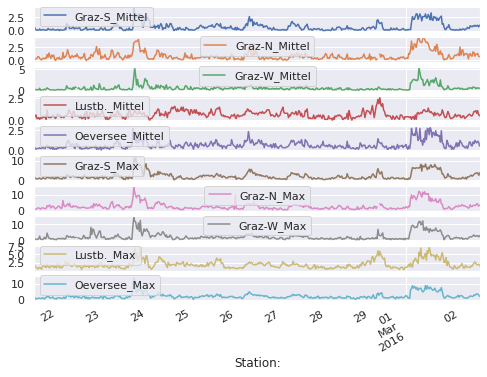

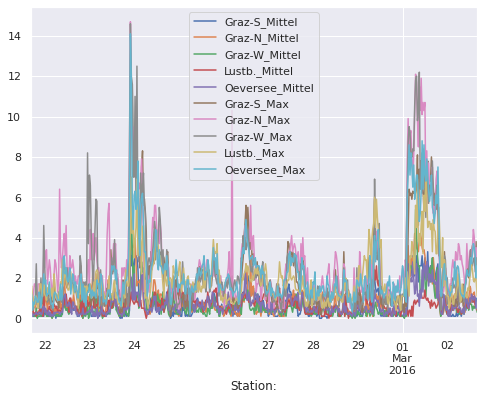

In [112]:
plot_cols = df.columns
plot_features = df[plot_cols][20000:20480]
plot_features.index = date_time[20000:20480]
p = plot_features.plot(subplots=True)


plot_features = df[plot_cols][20000:20480]
plot_features.index = date_time[20000:20480]
p = plot_features.plot(subplots=False)


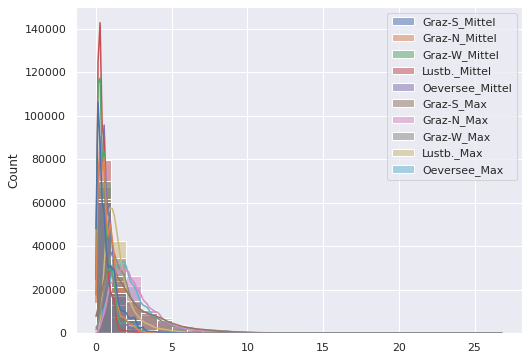

In [113]:
arr = np.array(range(df.min().min().astype('int'),df.max().max().astype('int')))

p = sns.histplot(df, kde=True, bins=arr)

Lustbühl schaut anders aus.

Erhebung in Graz, genauer anschauen

In [114]:
df.columns

Index(['Graz-S_Mittel', 'Graz-N_Mittel', 'Graz-W_Mittel', 'Lustb._Mittel',
       'Oeversee_Mittel', 'Graz-S_Max', 'Graz-N_Max', 'Graz-W_Max',
       'Lustb._Max', 'Oeversee_Max'],
      dtype='object')

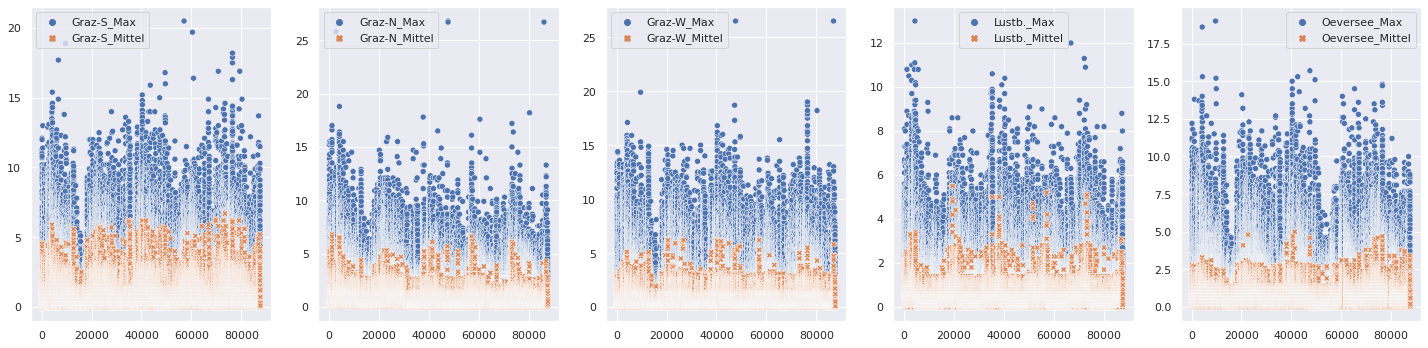

In [115]:
fig, axs = plt.subplots(ncols=5, figsize=(20,5))



for i in range(5):
    sns.scatterplot(data = df[[df.columns[i+5],df.columns[i]]],ax=axs[i])

    
fig.tight_layout()

fig.show()



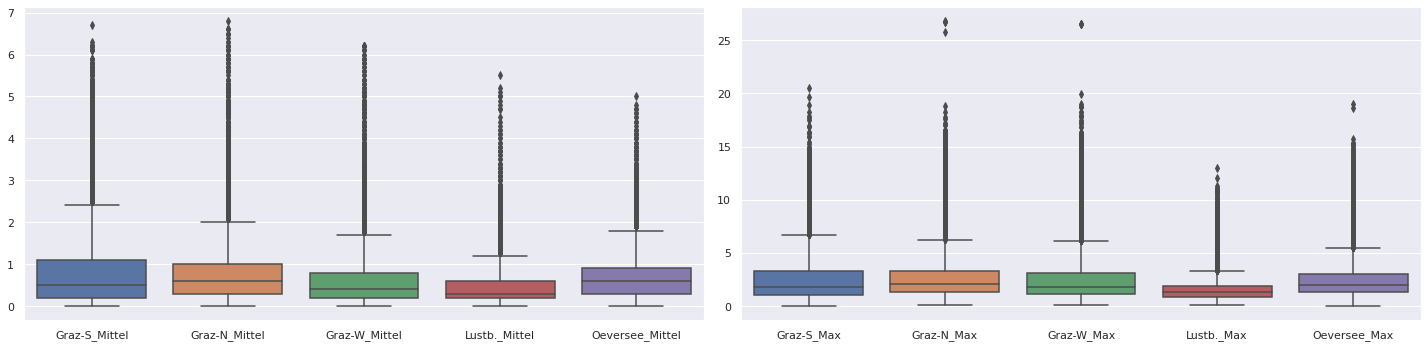

In [116]:
fig, axs = plt.subplots(ncols=2, figsize=(20,5))

sns.boxplot(data=df[df.columns[:5]],ax=axs[0])
sns.boxplot(data=df[df.columns[5:]],ax=axs[1])

fig.tight_layout()

fig.show()


### Besten Stationen

- Süd
- Nord
- West

- Lustb. -> weniger als Stadt
- Oeversee -> besser

## Windrichtung

In [117]:
df_windrichtung

Graz-DB  Graz-M G  Graz-S  Graz-O P  Graz-N  Graz-W  Lustb.  Oeversee  \
2          NaN       NaN   162.0       NaN   192.0   154.0   171.0     158.0   
3          NaN       NaN   157.0       NaN   207.0   161.0   234.0     158.0   
4          NaN       NaN   158.0       NaN   222.0   147.0   221.0     158.0   
5          NaN       NaN   160.0       NaN   222.0   157.0   173.0     158.0   
6          NaN       NaN   171.0       NaN   235.0   147.0   169.0     162.0   
...        ...       ...     ...       ...     ...     ...     ...       ...   
87645      NaN       NaN   270.0      42.0   331.0   331.0   246.0     358.0   
87646      NaN       NaN   331.0     314.0   316.0     0.0   290.0      16.0   
87647      NaN       NaN   219.0      43.0   327.0   344.0   180.0     297.0   
87648      NaN       NaN   277.0       4.0   304.0   297.0   169.0     314.0   
87649      NaN       NaN    19.0     356.0   315.0     4.0   167.0       2.0   

       Schloßb.  Plabut.  Kalkl.  Theissl.  Schöckl  Schöckl.1  
2         146.0    283.0     2.0       NaN      NaN      335.0  
3         142.0    276.0   352.0       NaN      NaN      332.0  
4         182.0    291.0   339.0       NaN      NaN      329.0  
5         147.0    294.0    11.0       NaN      NaN      329.0  
6         153.0    296.0   153.0       NaN      NaN      331.0  
...         ...      ...     ...       ...      ...        ...  
87645     294.0    231.0   296.0       NaN      NaN      326.0  
87646     347.0    252.0   256.0       NaN      NaN      326.0  
87647     305.0    189.0   178.0       NaN      NaN      324.0  
87648     237.0    181.0   210.0       NaN      NaN      317.0  
87649     195.0    169.0   172.0       NaN      NaN      315.0  

[87648 rows x 14 columns]

In [118]:
df = df_windrichtung[['Graz-S', 'Graz-N','Lustb.', 'Oeversee', 'Schloßb.']]

In [119]:
name = 'Windrichtung'

In [120]:
df.isna().sum()

Graz-S       272
Graz-N       539
Lustb.        13
Oeversee    1245
Schloßb.    7094
dtype: int64

In [121]:
df = df.drop(columns=['Schloßb.'])

In [122]:
df.describe().T

count        mean         std  min    25%    50%    75%    max
Graz-S    87376.0  191.528646   96.774347  0.0  126.0  166.0  289.0  360.0
Graz-N    87109.0  169.019447  127.815926  0.0   29.0  160.0  306.0  360.0
Lustb.    87635.0  164.257523  108.699998  0.0   57.0  175.0  240.0  360.0
Oeversee  86403.0  201.187563  116.875217  0.0  128.0  181.0  341.0  360.0

In [123]:
Stationen

Temp_NaN  Feucht>100  Feucht_NaN  Feucht_vrwbr  Druck_NaN  \
Graz-DB          10           0          10          True        NaN   
Graz-M G        156           0         157          True        NaN   
Graz-S          859           0         273          True        NaN   
Graz-O P      41673          38       41779         False        NaN   
Graz-N          538           0         538          True      538.0   
Graz-W           10          39         168          True        NaN   
Lustb.           13           0          13          True        NaN   
Oeversee        161         451        3537         False        NaN   
Schloßb.       5579           0        5229         False        NaN   
Plabut.          73         588        1188         False        NaN   
Kalkl.          766           2         383         False        NaN   
Theissl.       1542           0        1824         False        NaN   
Schöckl       87648           0       87648         False        NaN   
Schöckl.1      5995           0        6083         False     6006.0   

           Druck_vrwbr  Globalst_NaN  Niederschlag_NaN  Wind_NaN  
Graz-DB          False           NaN               NaN    175296  
Graz-M G         False           NaN               NaN    175296  
Graz-S           False           NaN               NaN       522  
Graz-O P         False           NaN               NaN     83412  
Graz-N            True        1572.0             550.0      1044  
Graz-W           False           NaN               NaN        28  
Lustb.           False        5675.0               NaN        26  
Oeversee         False           NaN               NaN      2498  
Schloßb.         False           NaN               NaN     13902  
Plabut.          False           NaN               NaN       226  
Kalkl.           False           NaN               NaN       720  
Theissl.         False           NaN               NaN    175296  
Schöckl          False           NaN               NaN    175296  
Schöckl.1        False        5964.0            6036.0     12040

In [124]:
Stationen['Windrichtung'] = df.isna().sum()

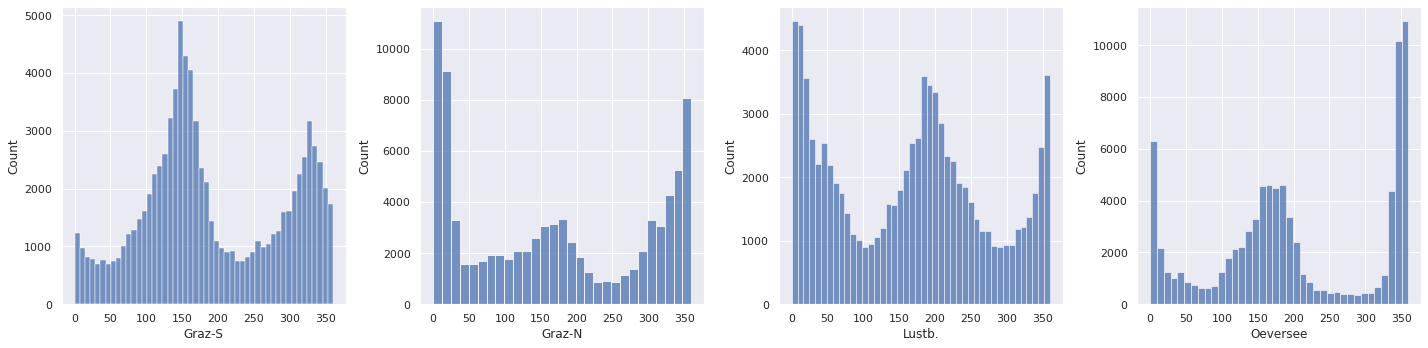

In [125]:
fig, axs = plt.subplots(ncols=4, figsize=(20,5))


for i in range(4):
    sns.histplot(data = df[df.columns[i]],ax=axs[i])

    
fig.tight_layout()

fig.show()


### Windrichtung könnte stimmen

- Graz Süden - Wind kommt von Süden
- Norden - vom Norden
- Lustb. hoch - Norden und Süden
- Oeversee - vom Norden oder Süden

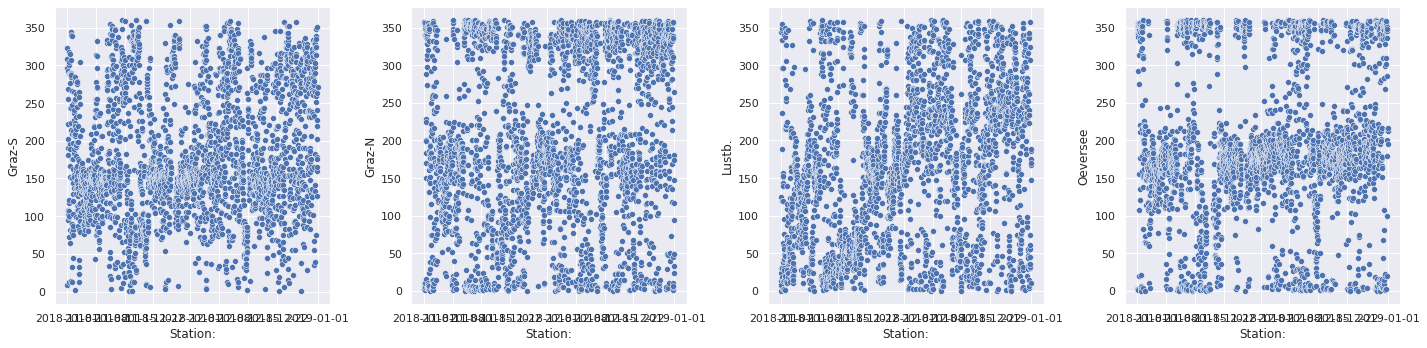

In [126]:
fig, axs = plt.subplots(ncols=4, figsize=(20,5))

df.index = windrichtung_date_time

for i in range(4):
    sns.scatterplot(data = df[df.columns[i]][(df.index < '2019-01-01') & (df.index > '2018-11-01')],ax=axs[i])
        
        
fig.tight_layout()

fig.show()


# Messstationenvergleich

Entscheidungshilfe für die Verwendung von Features

In [127]:
Stationen

Temp_NaN  Feucht>100  Feucht_NaN  Feucht_vrwbr  Druck_NaN  \
Graz-DB          10           0          10          True        NaN   
Graz-M G        156           0         157          True        NaN   
Graz-S          859           0         273          True        NaN   
Graz-O P      41673          38       41779         False        NaN   
Graz-N          538           0         538          True      538.0   
Graz-W           10          39         168          True        NaN   
Lustb.           13           0          13          True        NaN   
Oeversee        161         451        3537         False        NaN   
Schloßb.       5579           0        5229         False        NaN   
Plabut.          73         588        1188         False        NaN   
Kalkl.          766           2         383         False        NaN   
Theissl.       1542           0        1824         False        NaN   
Schöckl       87648           0       87648         False        NaN   
Schöckl.1      5995           0        6083         False     6006.0   

           Druck_vrwbr  Globalst_NaN  Niederschlag_NaN  Wind_NaN  Windrichtung  
Graz-DB          False           NaN               NaN    175296           NaN  
Graz-M G         False           NaN               NaN    175296           NaN  
Graz-S           False           NaN               NaN       522         272.0  
Graz-O P         False           NaN               NaN     83412           NaN  
Graz-N            True        1572.0             550.0      1044         539.0  
Graz-W           False           NaN               NaN        28           NaN  
Lustb.           False        5675.0               NaN        26          13.0  
Oeversee         False           NaN               NaN      2498        1245.0  
Schloßb.         False           NaN               NaN     13902           NaN  
Plabut.          False           NaN               NaN       226           NaN  
Kalkl.           False           NaN               NaN       720           NaN  
Theissl.         False           NaN               NaN    175296           NaN  
Schöckl          False           NaN               NaN    175296           NaN  
Schöckl.1        False        5964.0            6036.0     12040           NaN

In [128]:
Stationen.T.drop(columns=['Schloßb.','Graz-O P','Theissl.','Schöckl'])


Graz-DB Graz-M G Graz-S Graz-N Graz-W Lustb. Oeversee  \
Temp_NaN              10      156    859    538     10     13      161   
Feucht>100             0        0      0      0     39      0      451   
Feucht_NaN            10      157    273    538    168     13     3537   
Feucht_vrwbr        True     True   True   True   True   True    False   
Druck_NaN            NaN      NaN    NaN    538    NaN    NaN      NaN   
Druck_vrwbr        False    False  False   True  False  False    False   
Globalst_NaN         NaN      NaN    NaN   1572    NaN   5675      NaN   
Niederschlag_NaN     NaN      NaN    NaN    550    NaN    NaN      NaN   
Wind_NaN          175296   175296    522   1044     28     26     2498   
Windrichtung         NaN      NaN    272    539    NaN     13     1245   

                 Plabut. Kalkl. Schöckl.1  
Temp_NaN              73    766      5995  
Feucht>100           588      2         0  
Feucht_NaN          1188    383      6083  
Feucht_vrwbr       False  False     False  
Druck_NaN            NaN    NaN      6006  
Druck_vrwbr        False  False     False  
Globalst_NaN         NaN    NaN      5964  
Niederschlag_NaN     NaN    NaN      6036  
Wind_NaN             226    720     12040  
Windrichtung         NaN    NaN       NaN

## Besten Messstationen 



- Graz-DB
    - +
        - PM
        - Druck
        - Temp
        - Feucht
    - -
        - Wind
        - Niederschlag
        - Global
        
- Graz-M G
    - +
        - PM
        - Druck
        - Temp
        - Feucht
    - -
        - Wind
        - Niederschlag
        - Global
- Graz-S
    - +
        - (PM)
        - Druck
        - Wind
        - (Temp)
        - Feucht
    - -
        - Niederschlag
        - Global
- Graz-N
    - +
        - (PM)
        - Niederschlag
        - Gobalstrahlung
        - Druck
        - Wind
        - Temp
        - (Feucht)
- Graz-W
    - +
        - Druck
        - PM
        - Temp
        - Feucht
    - -
        - Wind
        - Global
        - Niederschlag
- Oeversee
    - +
        - (PM)
        - Wind
        - Temp 
        - Feucht
    - -
        - Niederschlag
        - Druck
        - Global

anders

- Lustb.
- Plabut.
- Kalkl.
- Schöckl.1
    - +
        - Niederschlag
    - -
        - PM
        
        
        
        
        
**Graz_N scheint vielversprehenste Station zu sein**